Fetching evaluation data for Unknown Student to USJ-R Main Campus
Successfully fetched data for Unknown Student to USJ-R Main Campus

Creating comprehensive visualization for Main Campus...
Values: [0.5, 0.5, 0.5, 0.8903358323919072, 0.5]
Data Type: <class 'list'>


C:\Users\USER\AppData\Local\Temp\ipykernel_14844\2092625271.py:108: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved visualization to route_analysis_main_20250402_024609.png


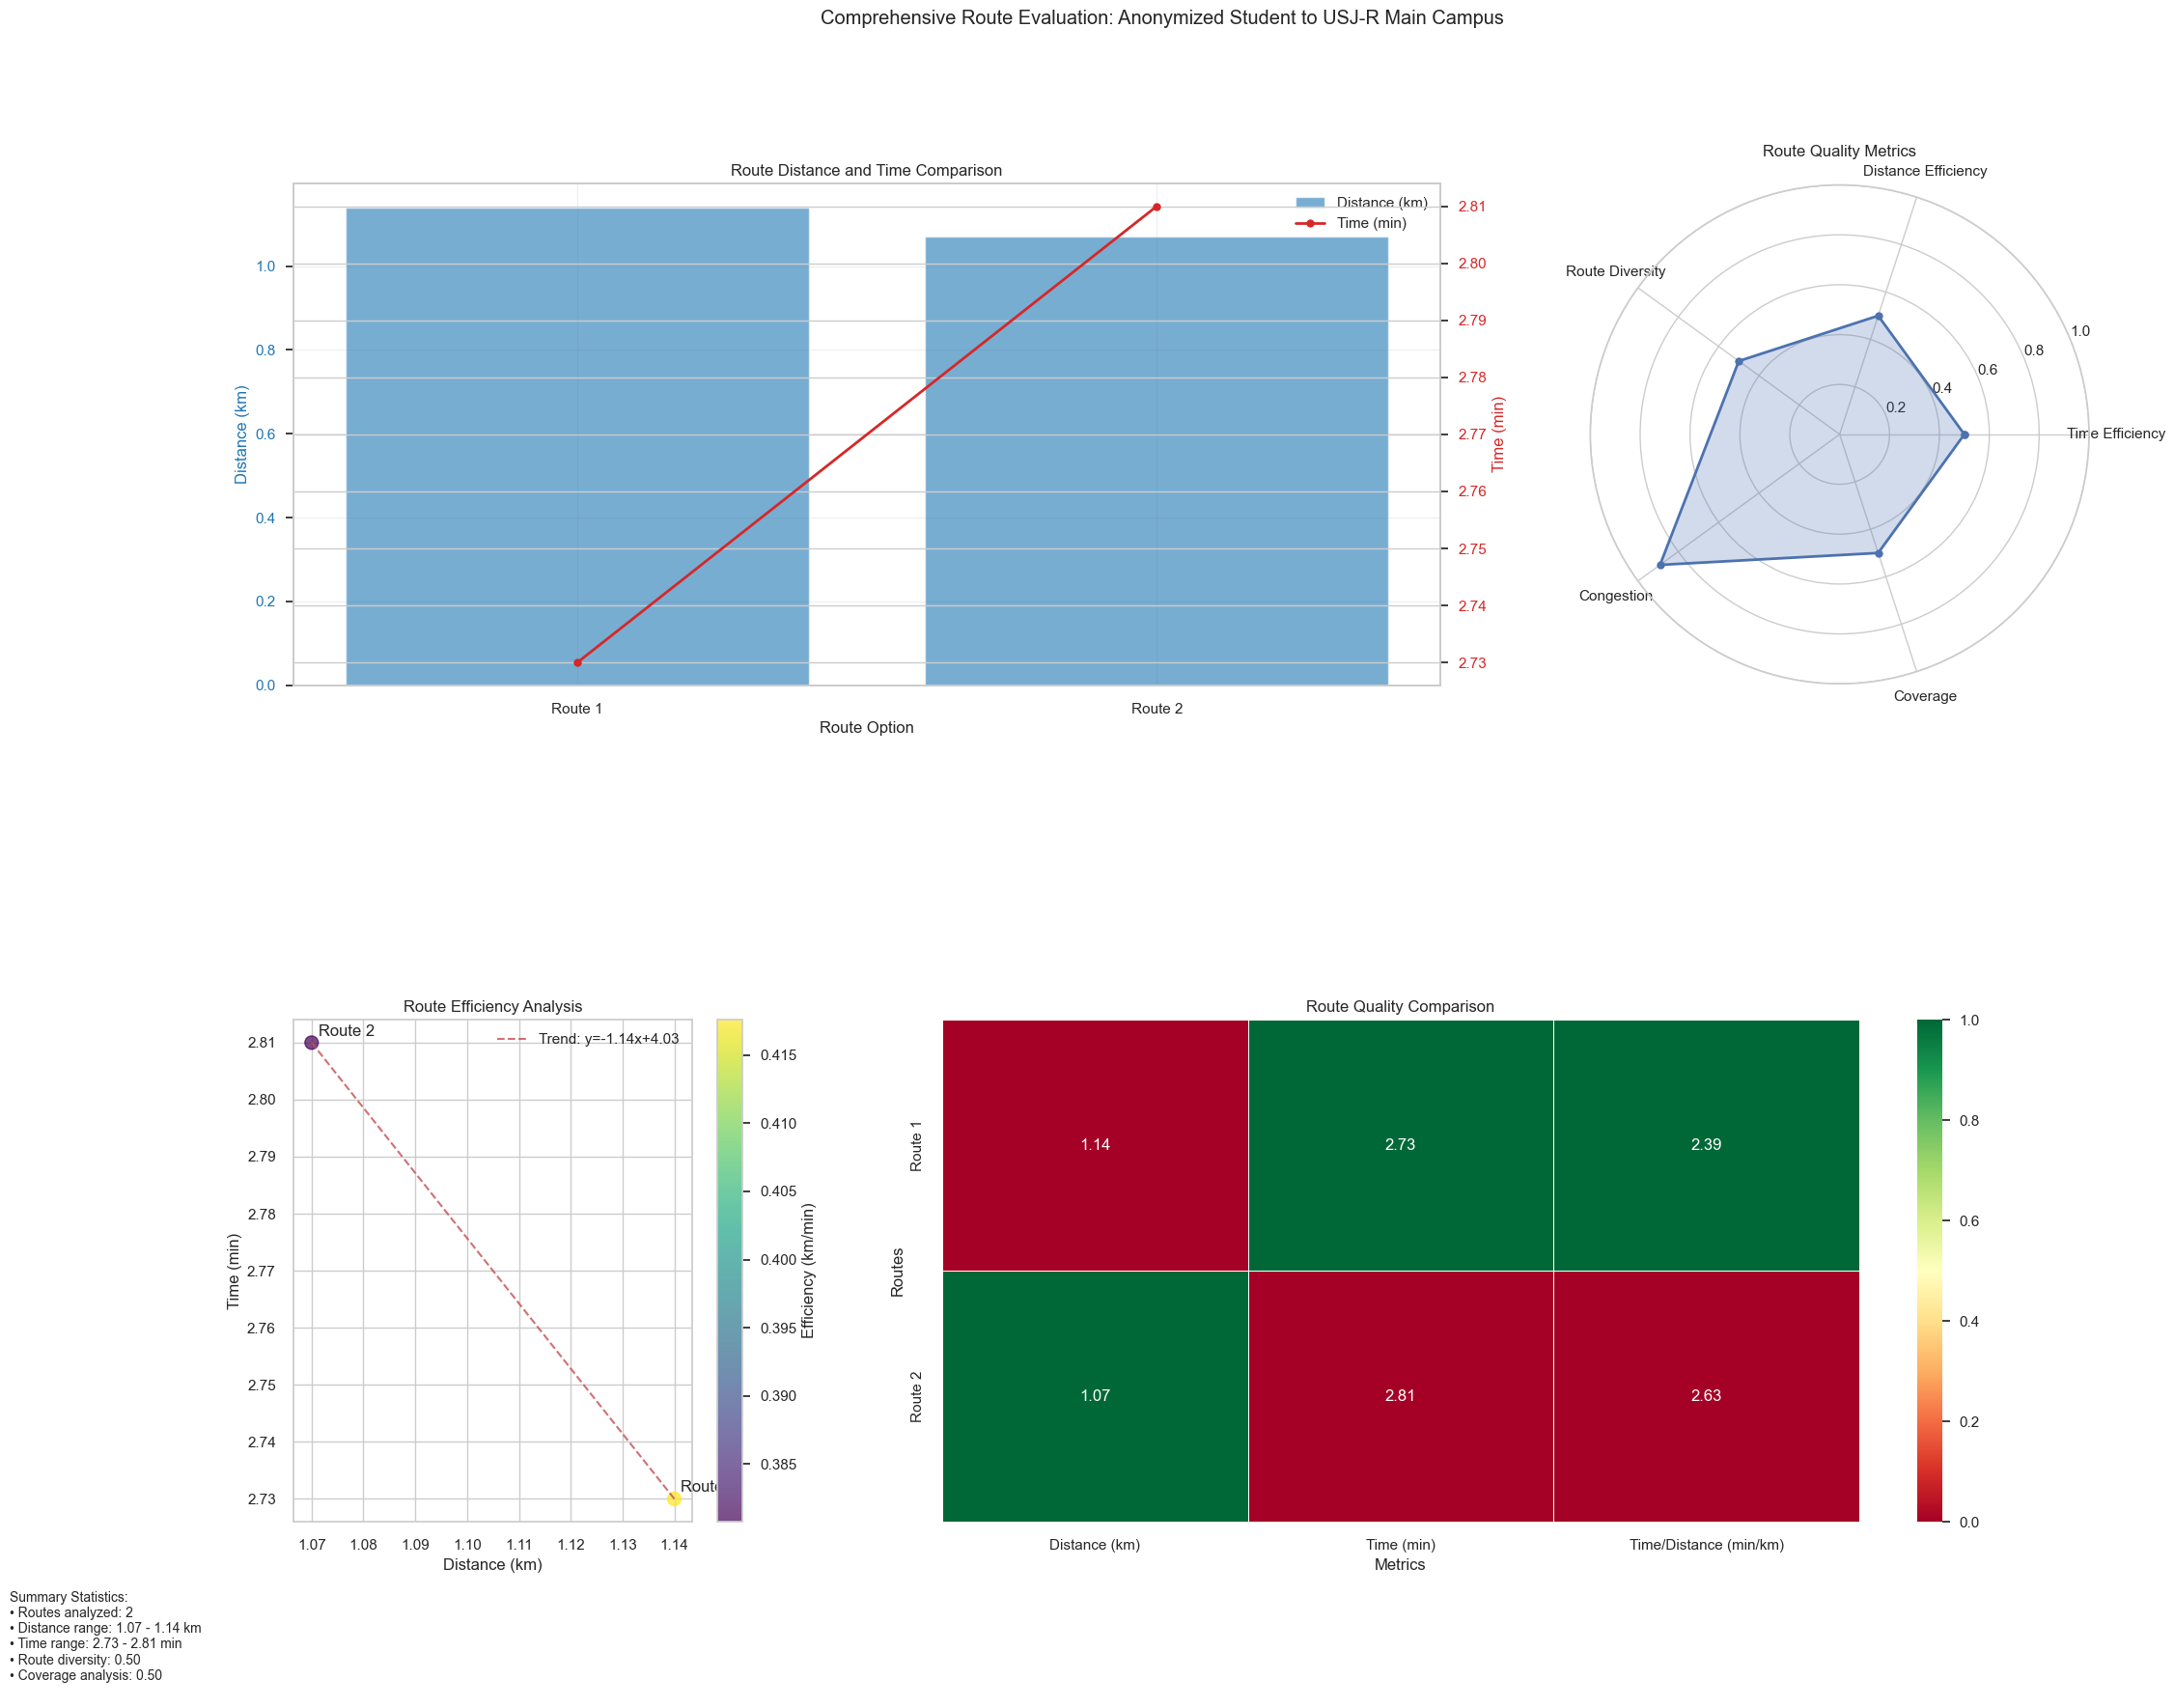

Fetching evaluation data for Unknown Student to USJ-R Basak Campus
Successfully fetched data for Unknown Student to USJ-R Basak Campus

Creating comprehensive visualization for Basak Campus...
Values: [0.5, 0.5, 0.5, 0.8655986191950062, 0.5]
Data Type: <class 'list'>


C:\Users\USER\AppData\Local\Temp\ipykernel_14844\2092625271.py:108: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved visualization to route_analysis_basak_20250402_024609.png


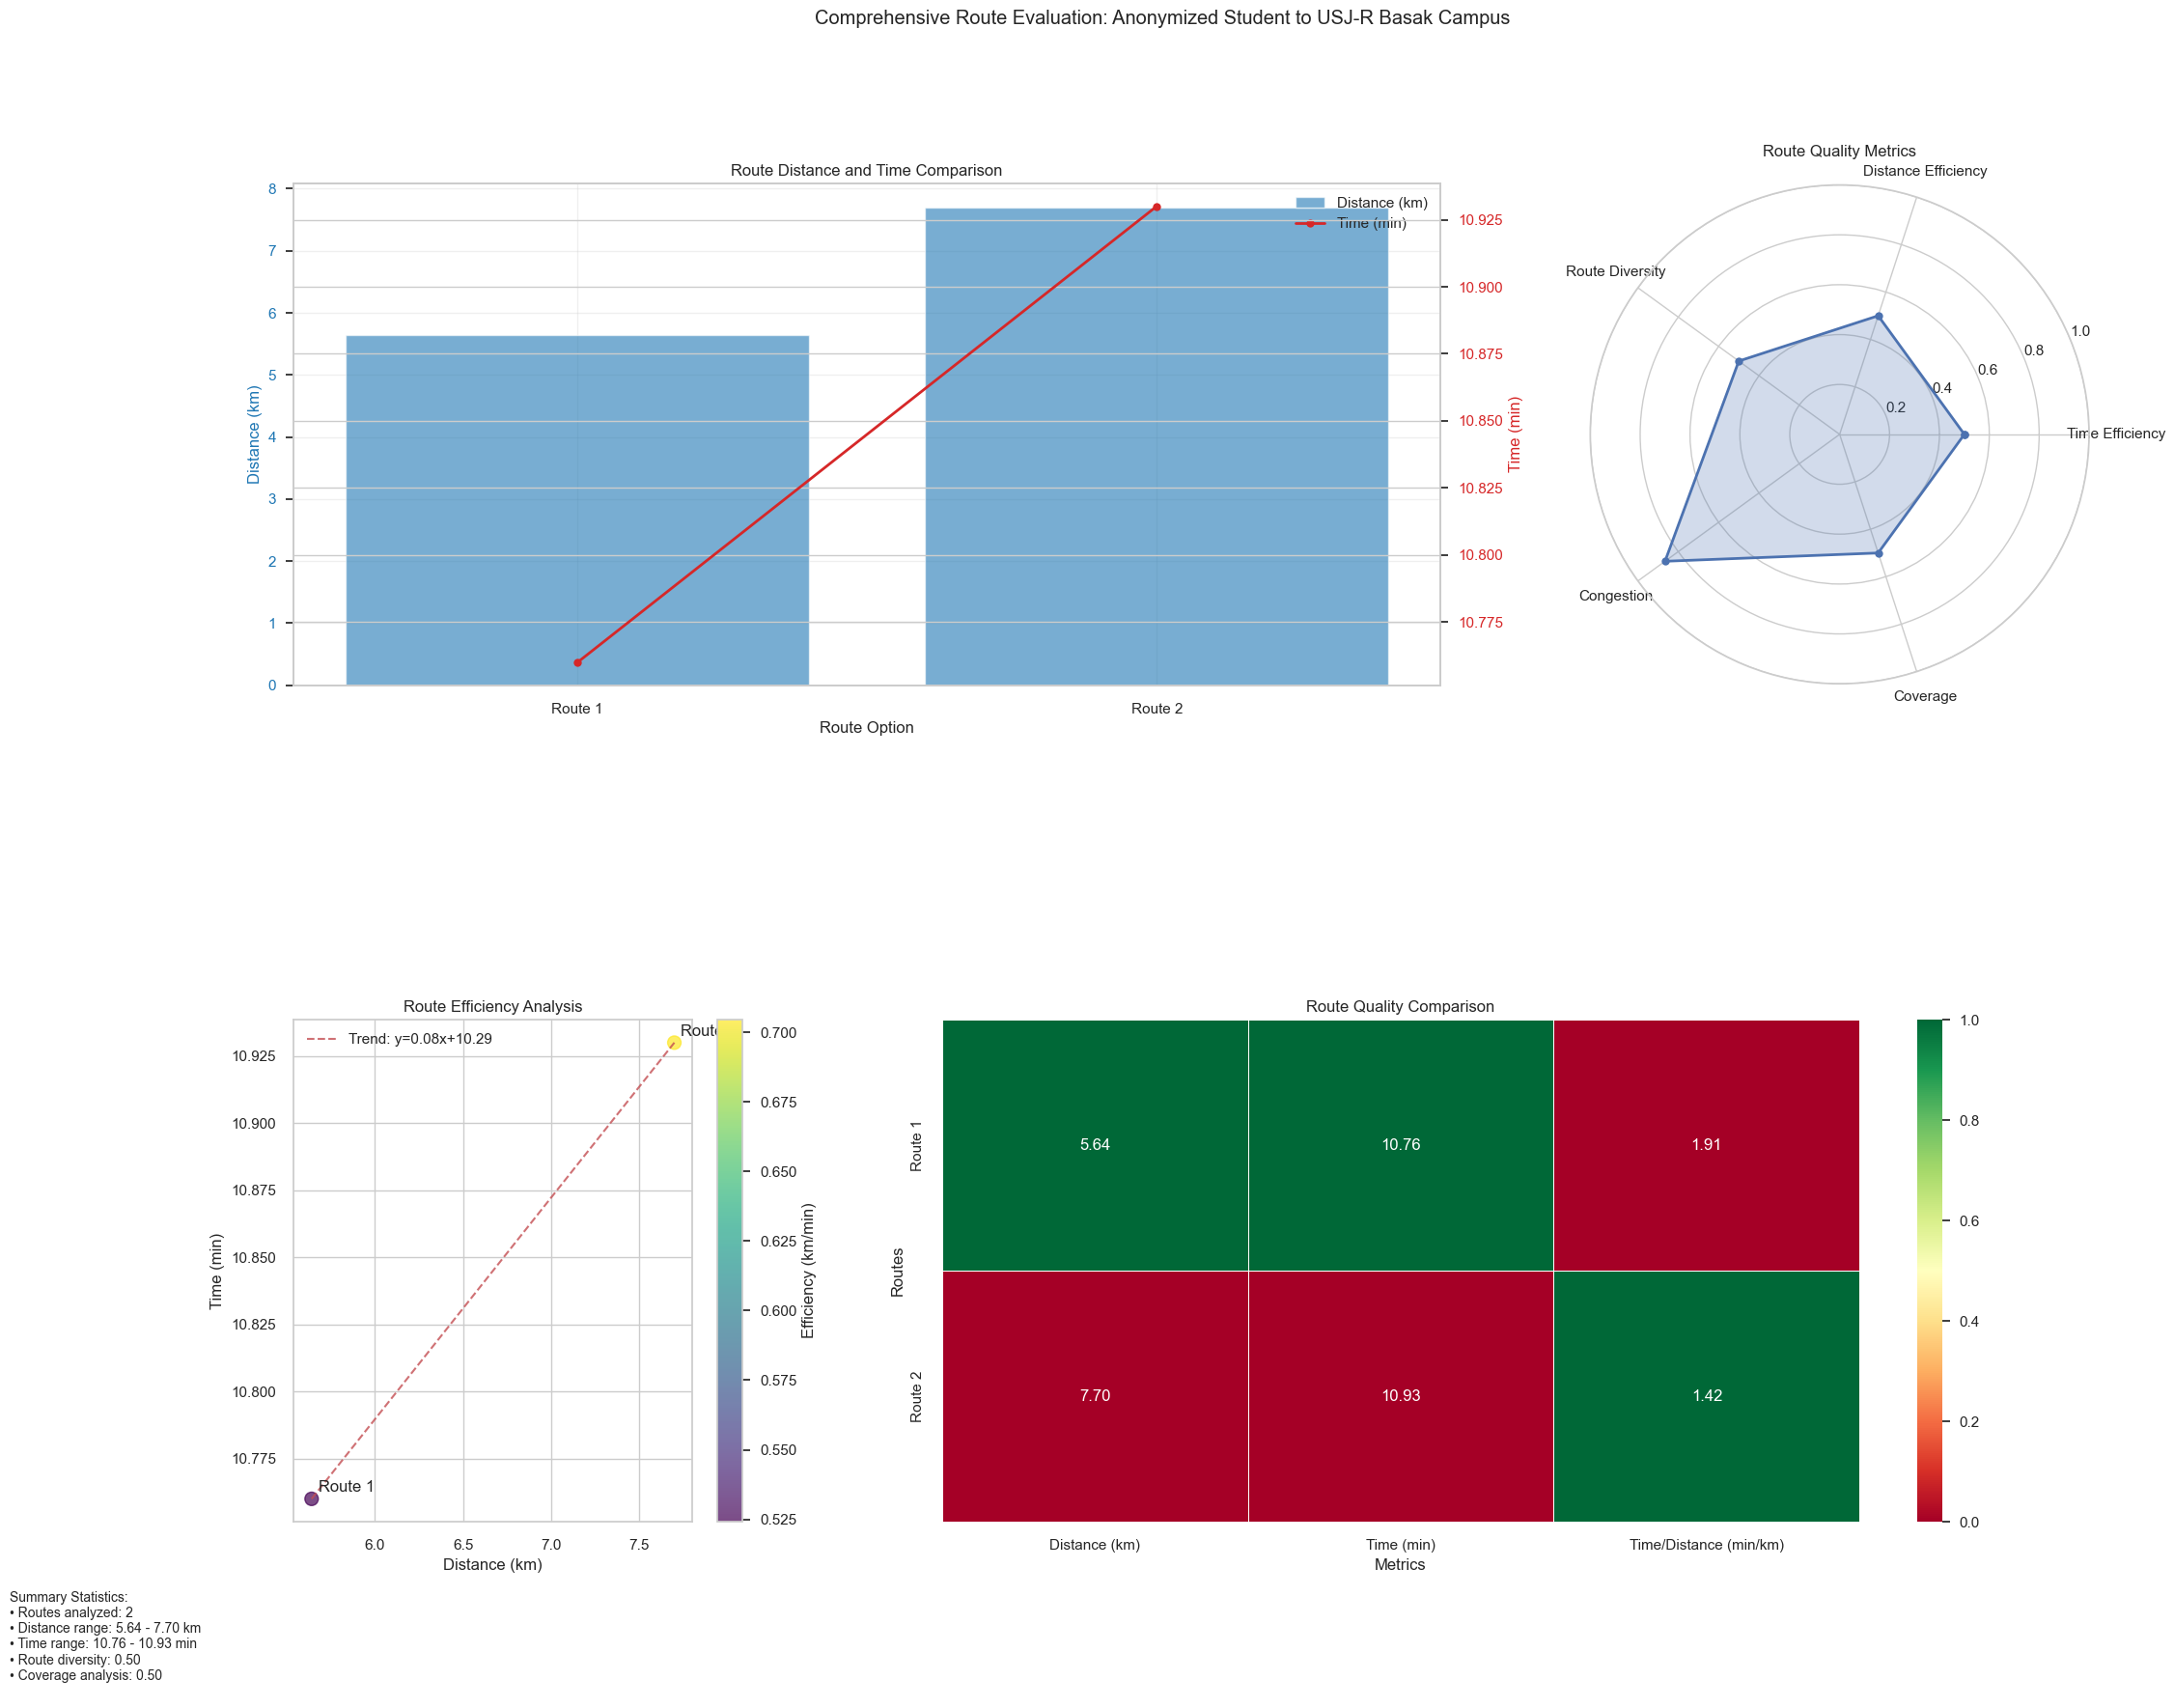


Analysis complete! Files saved with timestamp: 20250402_024609


In [106]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from datetime import datetime

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style that exists
sns.set_theme(style="whitegrid")

def fetch_route_data(student="Unknown Student", campus="USJ-R Main Campus"):
    """
    Fetch the latest route evaluation data from the backend API.
    """
    API_URL = "http://localhost:8000/evaluate-routes"
    
    print(f"Fetching evaluation data for {student} to {campus}")
    
    try:
        response = requests.get(API_URL, params={
            "student_name": student,
            "campus_name": campus
        })
        
        response.raise_for_status()
        api_data = response.json()
        print(f"Successfully fetched data for {student} to {campus}")
        return api_data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP Error: {http_err}")
        print(f"Response status: {response.status_code}")
        print(f"Response body: {response.text}")
        raise


def create_route_dataframe(route_data):
    """Convert route data into a pandas DataFrame for easier manipulation."""
    # Extract route metrics
    distances = route_data['distanceStats']['values']
    times = route_data['timeStats']['values']
    
    # Create route labels
    route_labels = [f"Route {i+1}" for i in range(len(distances))]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Route': route_labels,
        'Distance (km)': distances,
        'Time (min)': times,
        'Time/Distance (min/km)': [t/d for t, d in zip(times, distances)]
    })
    
    # Add route quality metrics if available
    if 'efficiencyMetrics' in route_data:
        if 'routeQualityScores' in route_data['efficiencyMetrics']:
            df['Quality Score'] = route_data['efficiencyMetrics']['routeQualityScores']
    
    return df

def visualize_comprehensive_evaluation(route_data, save_path=None):
    """Create a comprehensive dashboard of route evaluation metrics."""
    # Create a DataFrame for easier manipulation
    df = create_route_dataframe(route_data)
    
    # Set up the figure with a grid layout
    fig = plt.figure(figsize=(24, 18))
    gs = gridspec.GridSpec(
        nrows=3, 
        ncols=3, 
        figure=fig,
        height_ratios=[1, 0.5, 1],
        hspace=0.1,
        wspace=0.3
    )
    
    # Extract metadata
    student = route_data['metadata']['studentName']
    campus = route_data['metadata']['campusName']
    route_count = route_data['metadata']['routeCount']
    calc_time = route_data['metadata']['calculationTimestamp']
    
    # Add a title to the entire figure
    fig.suptitle(f'Comprehensive Route Evaluation: Anonymized Student to {campus}\n')
    
    # Distance and Time Comparison (Bar & Line)
    ax1 = fig.add_subplot(gs[0, 0:2])
    create_distance_time_plot(df, ax1)
    
    # Route Quality Radar Chart
    ax2 = fig.add_subplot(gs[0, 2], polar=True)
    create_route_quality_radar(route_data, ax2)
    
    # Route Efficiency Scatter Plot
    ax6 = fig.add_subplot(gs[2, 0])
    create_efficiency_scatter(df, ax6)
    
    # Route Quality Heatmap
    ax7 = fig.add_subplot(gs[2, 1:3])
    create_route_quality_heatmap(route_data, ax7)
    
    # Add summary statistics as text
    add_summary_statistics(route_data, fig)
    
    # Adjust layout
    plt.tight_layout(rect=[0.2, 0.03, 1, 0.95])

    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()
    
    return df

def create_distance_time_plot(df, ax):
    """Create a combined distance (bar) and time (line) plot."""
    route_labels = df['Route']
    distances = df['Distance (km)']
    times = df['Time (min)']
    
    # Plot distance bars
    color1 = 'tab:blue'
    ax.bar(route_labels, distances, color=color1, alpha=0.6, label='Distance (km)')
    ax.set_xlabel('Route Option')
    ax.set_ylabel('Distance (km)', color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    
    # Create twin axis for time
    ax2 = ax.twinx()
    color2 = 'tab:red'
    ax2.plot(route_labels, times, color=color2, marker='o', linestyle='-', 
             linewidth=2, label='Time (min)')
    ax2.set_ylabel('Time (min)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    ax.set_title('Route Distance and Time Comparison')
    ax.grid(True, alpha=0.3)

def create_route_quality_radar(route_data, ax):
    """Create a radar chart showing route quality metrics."""
    # Define categories for radar chart
    categories = ['Time Efficiency', 'Distance Efficiency', 
                  'Route Diversity', 'Congestion', 'Coverage']
    
    # Extract values (normalize between 0-1)
    values = []
    
    # Check if metrics exist and add defaults if not
    if 'efficiencyMetrics' in route_data:
        metrics = route_data['efficiencyMetrics']
        values.append(metrics.get('timeEfficiency', 0.5))
        values.append(metrics.get('distanceEfficiency', 0.5))
    else:
        values.append(0.5)  # Default time efficiency
        values.append(0.5)  # Default distance efficiency
    
    # Add route diversity
    values.append(route_data.get('routeDiversity', {}).get('diversityScore', 0.5))
    
    # Add congestion (invert so lower is better)
    if 'efficiencyMetrics' in route_data and 'congestionScore' in route_data['efficiencyMetrics']:
        values.append(1 - (route_data['efficiencyMetrics']['congestionScore'] / 10))
    else:
        values.append(0.5)  # Default congestion
    
    # Add coverage - FIX: Handle the case when coverageAnalysis is a dictionary
    coverage_value = route_data.get('coverageAnalysis', 0.5)
    if isinstance(coverage_value, dict):
        # Extract the value from the dictionary or use default
        coverage_value = coverage_value.get('coverageRatio', 0.5)
    values.append(coverage_value)
    
    # Debug print
    print("Values:", values)
    print("Data Type:", type(values))
    
    # Make sure all values are numeric
    for i, val in enumerate(values):
        if not isinstance(val, (int, float)):
            print(f"Warning: Non-numeric value found at index {i}: {val}, replacing with 0.5")
            values[i] = 0.5
    
    # Calculate angles for each category
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    
    # Close the loop for both angles and values
    values.append(values[0])
    categories.append(categories[0])
    angles.append(angles[0])
    
    # Now both values and angles have the same length
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories[:-1])
    ax.set_ylim(0, 1)
    ax.set_title('Route Quality Metrics')
    ax.grid(True)


def create_efficiency_scatter(df, ax):
    """Create a scatter plot of time vs distance with efficiency indicators."""
    # Calculate efficiency as distance/time (lower is better)
    df['Efficiency'] = df['Distance (km)'] / df['Time (min)']
    
    # Create scatter plot
    scatter = ax.scatter(df['Distance (km)'], df['Time (min)'], 
                         c=df['Efficiency'], cmap='viridis', 
                         s=100, alpha=0.7)
    
    # Add route labels
    for i, row in df.iterrows():
        ax.annotate(row['Route'], 
                    (row['Distance (km)'], row['Time (min)']),
                    xytext=(5, 5), textcoords='offset points')
    
    # Add color bar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Efficiency (km/min)')
    
    # Add a line of best fit
    x = df['Distance (km)']
    y = df['Time (min)']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8, label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}")
    
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Time (min)')
    ax.set_title('Route Efficiency Analysis')
    ax.grid(True)
    ax.legend()

def create_route_quality_heatmap(route_data, ax):
    """Create a heatmap showing route quality metrics for each route."""
    # Extract metrics
    route_count = route_data['metadata']['routeCount']
    route_labels = [f"Route {i+1}" for i in range(route_count)]
    
    # Define metrics to include in heatmap
    metrics = [
        ('Distance (km)', [d for d in route_data['distanceStats']['values']]),
        ('Time (min)', [t for t in route_data['timeStats']['values']])
    ]
    
    # Check if we can calculate time/distance ratio
    if len(route_data['distanceStats']['values']) == len(route_data['timeStats']['values']):
        metrics.append(('Time/Distance (min/km)', [t/d for t, d in zip(
            route_data['timeStats']['values'], 
            route_data['distanceStats']['values'])]))
    
    # Add quality score if available
    if 'efficiencyMetrics' in route_data and 'routeQualityScores' in route_data['efficiencyMetrics']:
        metrics.append(('Quality Score', route_data['efficiencyMetrics']['routeQualityScores']))
    
    # Create a DataFrame for the heatmap
    heatmap_data = pd.DataFrame({metric[0]: metric[1] for metric in metrics}, index=route_labels)
    
    # Create a normalized version for the heatmap colors
    normalized_data = heatmap_data.copy()
    for col in normalized_data.columns:
        if col in ['Distance (km)', 'Time (min)', 'Time/Distance (min/km)']:
            # For these metrics, lower is better
            min_val = normalized_data[col].min()
            max_val = normalized_data[col].max()
            if min_val != max_val:  # Avoid division by zero
                normalized_data[col] = 1 - (normalized_data[col] - min_val) / (max_val - min_val)
            else:
                normalized_data[col] = 0.5  # All values are the same
        else:
            # For quality score, higher is better
            min_val = normalized_data[col].min()
            max_val = normalized_data[col].max()
            if min_val != max_val:  # Avoid division by zero
                normalized_data[col] = (normalized_data[col] - min_val) / (max_val - min_val)
            else:
                normalized_data[col] = 0.5  # All values are the same
    
    # Create the heatmap
    sns.heatmap(normalized_data, annot=heatmap_data, fmt=".2f", 
                cmap="RdYlGn", ax=ax, linewidths=0.5)
    
    ax.set_title('Route Quality Comparison')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Routes')

def add_summary_statistics(route_data, fig):
    """Add summary statistics as text to the figure."""
    # Create a text box with summary statistics
    summary_text = (
        f"Summary Statistics:\n"
        f"• Routes analyzed: {route_data['metadata']['routeCount']}\n"
        f"• Distance range: {route_data['distanceStats']['min']:.2f} - {route_data['distanceStats']['max']:.2f} km\n"
        f"• Time range: {route_data['timeStats']['min']:.2f} - {route_data['timeStats']['max']:.2f} min\n"
    )
    
    # Add route diversity if available
    if 'routeDiversity' in route_data and 'diversityScore' in route_data['routeDiversity']:
        summary_text += f"• Route diversity: {route_data['routeDiversity']['diversityScore']:.2f}\n"
    
    # Add coverage analysis if available - FIX: Handle the case when coverageAnalysis is a dictionary
    if 'coverageAnalysis' in route_data:
        coverage_value = route_data['coverageAnalysis']
        if isinstance(coverage_value, dict):
            # Extract the value from the dictionary or use default
            if 'coverageRatio' in coverage_value:
                summary_text += f"• Coverage analysis: {coverage_value['coverageRatio']:.2f}\n"
            else:
                summary_text += f"• Coverage analysis: Data available but format unknown\n"
        else:
            # If it's a numeric value, format it normally
            try:
                summary_text += f"• Coverage analysis: {float(coverage_value):.2f}\n"
            except (ValueError, TypeError):
                summary_text += f"• Coverage analysis: Data available but not numeric\n"
   
    # Add text to the figure
    fig.text(0.0025, 0.01, summary_text, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

# Function to safely extract metrics from API data with default values
def extract_metric_with_default(data, metric_path, default_value=None):
    """Safely extract metrics from nested dictionaries with fallback defaults."""
    current = data
    for key in metric_path.split('.'):
        if isinstance(current, dict) and key in current:
            current = current[key]
        else:
            return default_value
    return current

from datetime import datetime

# --- Main function to run the comprehensive analysis ---
def run_comprehensive_analysis(student_name="Unknown Student"):
    """Run a comprehensive analysis for a student to all campuses."""
    # Current timestamp for output files
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    try:
        # Analyze for main campus
        main_campus_data = fetch_route_data(student=student_name, campus="USJ-R Main Campus")
        print("\nCreating comprehensive visualization for Main Campus...")
        main_df = visualize_comprehensive_evaluation(
            main_campus_data, 
            save_path=f"route_analysis_main_{timestamp}.png"
        )
        
        # Try to analyze for Basak campus
        try:
            basak_campus_data = fetch_route_data(student=student_name, campus="USJ-R Basak Campus")
            print("\nCreating comprehensive visualization for Basak Campus...")
            basak_df = visualize_comprehensive_evaluation(
                basak_campus_data,
                save_path=f"route_analysis_basak_{timestamp}.png"
            )
        except Exception as e:
            print(f"Error processing Basak Campus: {e}")
            import traceback
            traceback.print_exc()

        print(f"\nAnalysis complete! Files saved with timestamp: {timestamp}")
        return True        
    
    except Exception as e:
        print(f"Error in comprehensive analysis: {e}")
        import traceback
        traceback.print_exc()
        return False

# Run the analysis if this script is executed directly
if __name__ == "__main__":
    run_comprehensive_analysis()


Fetching evaluation data for Unknown Student to USJ-R Main Campus
Successfully fetched data for Unknown Student to USJ-R Main Campus

Creating comprehensive visualization for Main Campus...


C:\Users\USER\AppData\Local\Temp\ipykernel_14844\3338401731.py:157: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved visualization to route_analysis_main_20250402_064858.png


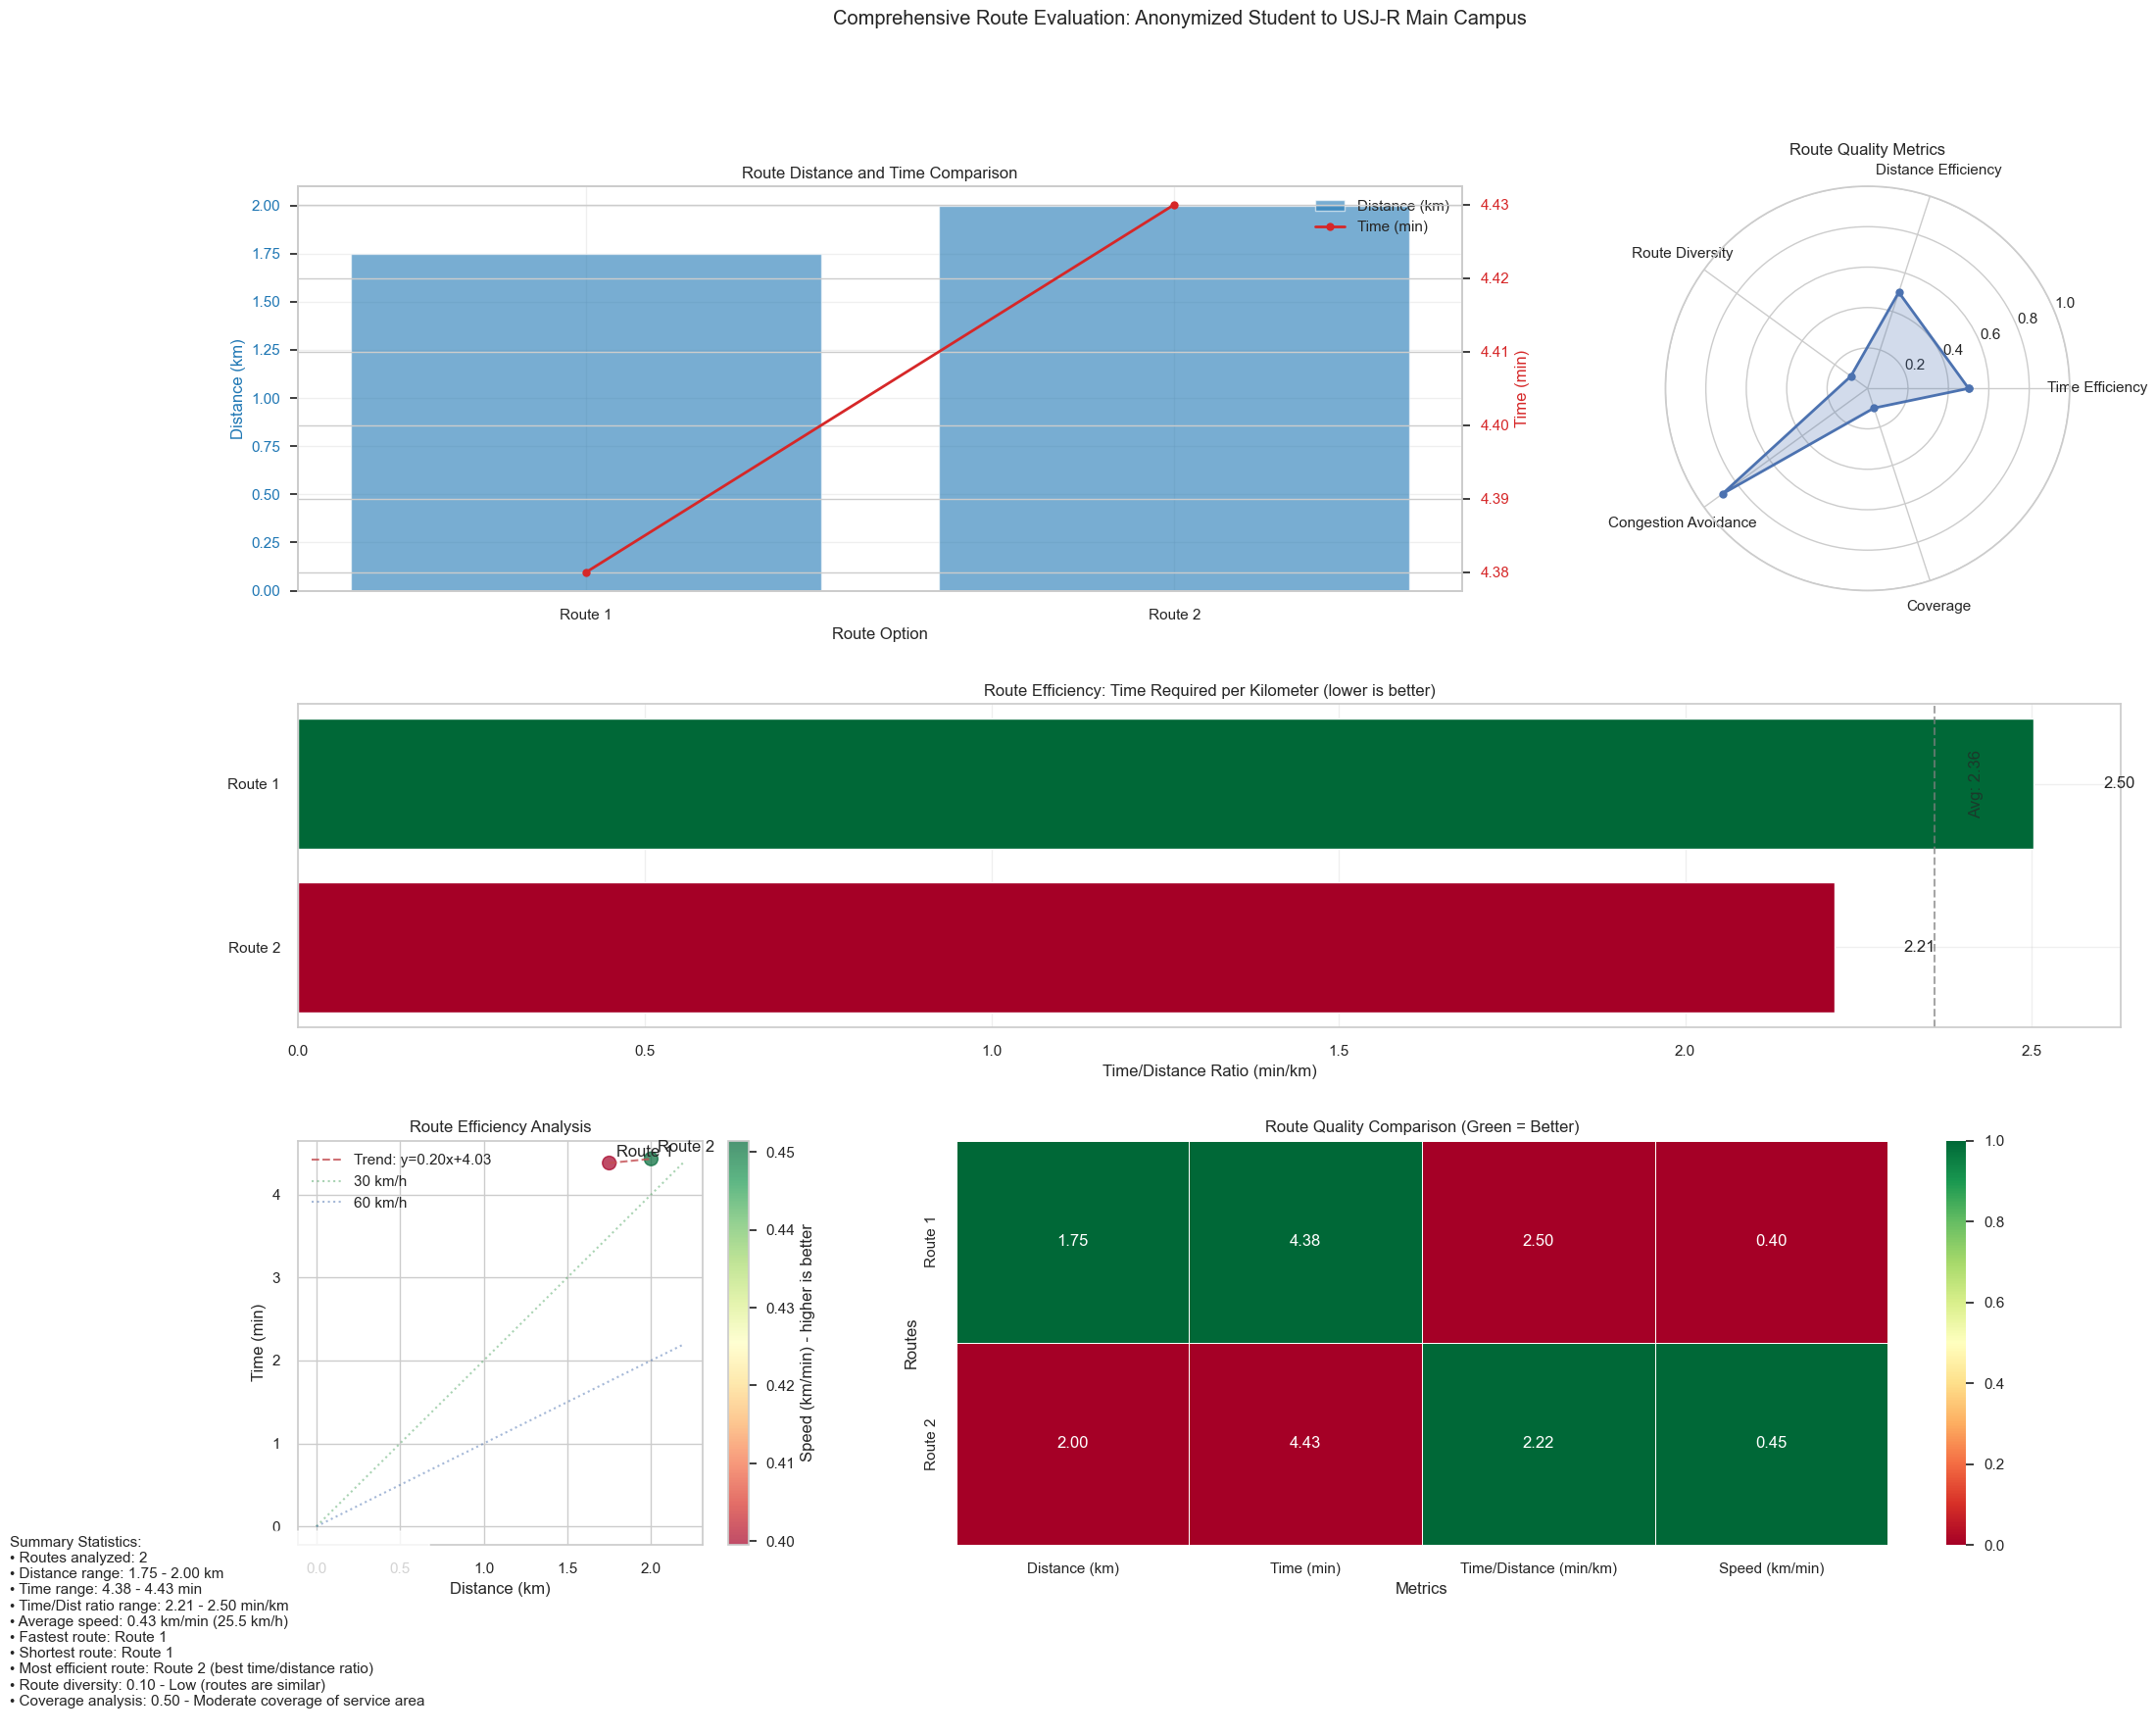

Fetching evaluation data for Unknown Student to USJ-R Basak Campus
Successfully fetched data for Unknown Student to USJ-R Basak Campus

Creating comprehensive visualization for Basak Campus...


C:\Users\USER\AppData\Local\Temp\ipykernel_14844\3338401731.py:157: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved visualization to route_analysis_basak_20250402_064858.png


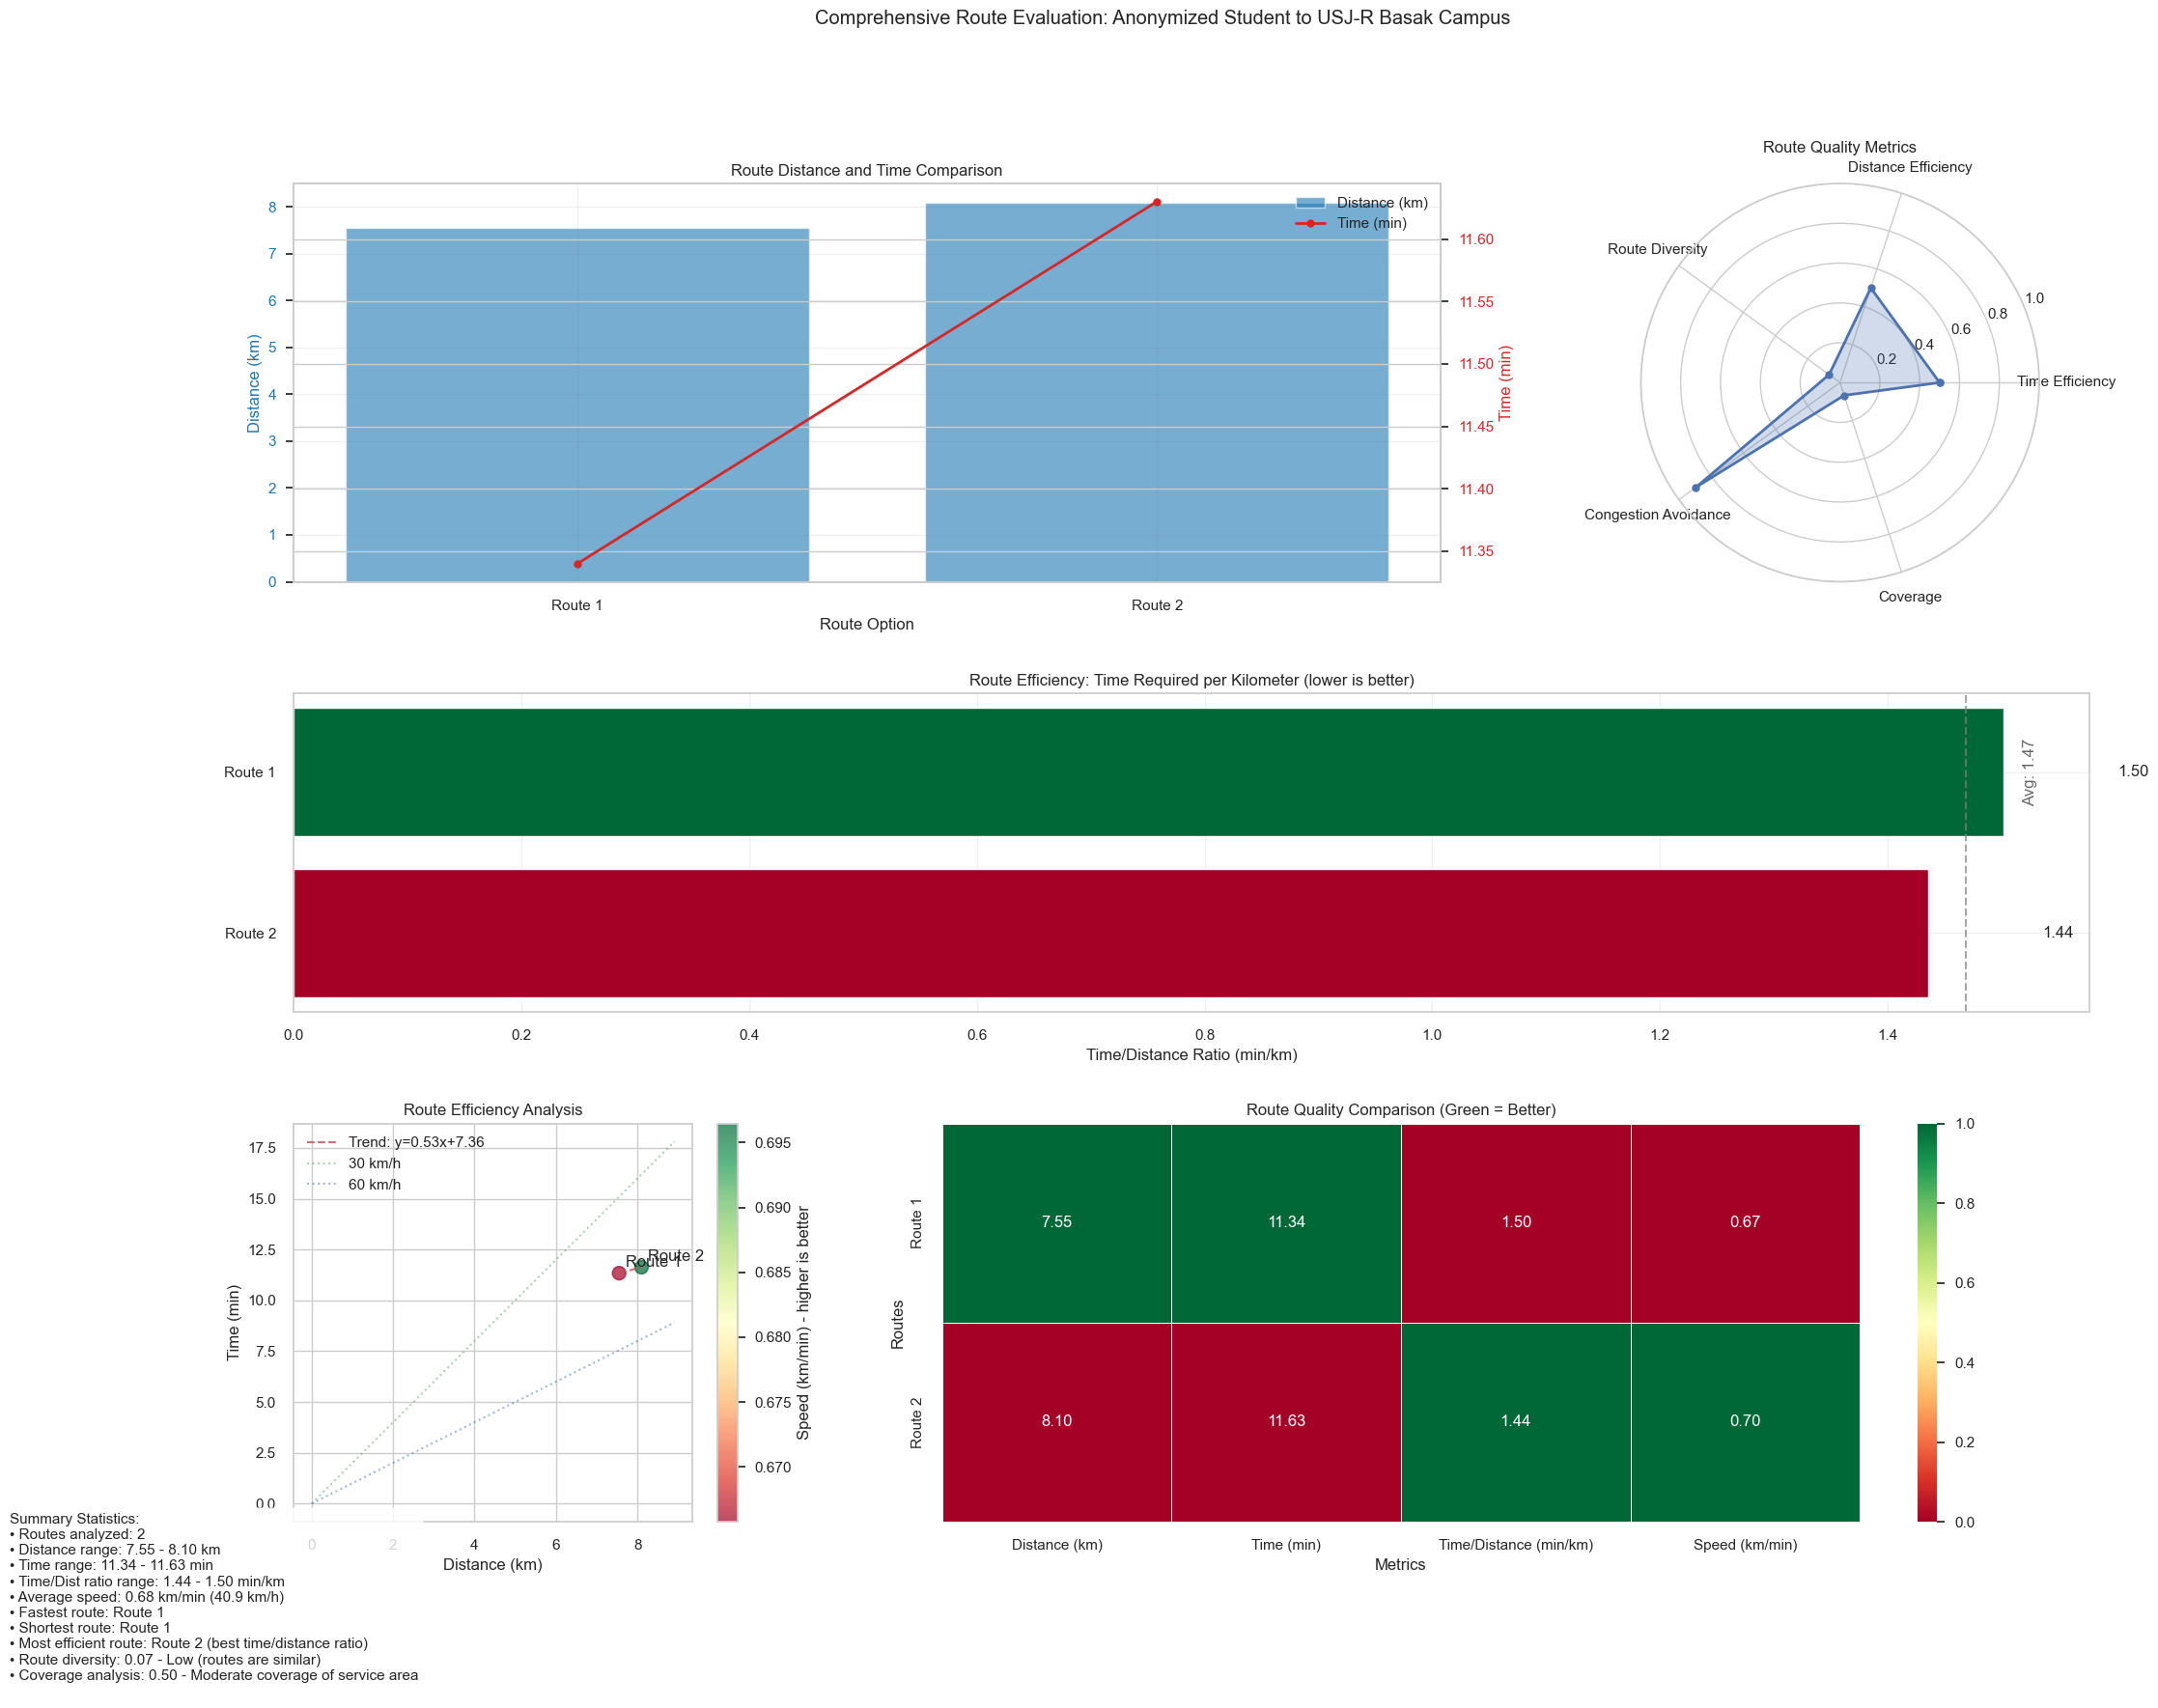


Analysis complete! Files saved with timestamp: 20250402_064858


In [107]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from datetime import datetime

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

def fetch_route_data(student="Unknown Student", campus="USJ-R Main Campus"):
    """
    Fetch the latest route evaluation data from the backend API.
    """
    API_URL = "http://localhost:8000/evaluate-routes"
    
    print(f"Fetching evaluation data for {student} to {campus}")
    
    try:
        response = requests.get(API_URL, params={
            "student_name": student,
            "campus_name": campus
        })
        
        response.raise_for_status()
        api_data = response.json()
        print(f"Successfully fetched data for {student} to {campus}")
        return api_data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP Error: {http_err}")
        print(f"Response status: {response.status_code}")
        print(f"Response body: {response.text}")
        raise


def create_route_dataframe(route_data):
    """Convert route data into a pandas DataFrame for easier manipulation."""
    # Extract route metrics
    distances = route_data['distanceStats']['values']
    times = route_data['timeStats']['values']
    
    # Create route labels
    route_labels = [f"Route {i+1}" for i in range(len(distances))]
    
    # Calculate time-distance ratio (efficiency metric)
    time_distance_ratios = [t/d for t, d in zip(times, distances)]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Route': route_labels,
        'Distance (km)': distances,
        'Time (min)': times,
        'Time/Distance (min/km)': time_distance_ratios,
        # Add inverse ratio (km/min) - higher is better
        'Speed (km/min)': [d/t for t, d in zip(times, distances)],
        # Normalized time efficiency (0-1) - higher is better
        'Time Efficiency': normalize_inverse([t/d for t, d in zip(times, distances)])
    })
    
    # Add route quality metrics if available
    if 'efficiencyMetrics' in route_data:
        if 'routeQualityScores' in route_data['efficiencyMetrics']:
            df['Quality Score'] = route_data['efficiencyMetrics']['routeQualityScores']
    
    # Calculate custom coverage and diversity if not provided meaningfully
    if 'routeDiversity' not in route_data or route_data.get('routeDiversity', {}).get('diversityScore', 0.5) == 0.5:
        df['Route Diversity'] = calculate_route_diversity(df)
    else:
        df['Route Diversity'] = route_data['routeDiversity']['diversityScore']
    
    return df

def normalize_inverse(values):
    """Normalize values where lower raw values are better (like time/distance ratio)."""
    if len(values) <= 1 or max(values) == min(values):
        return [0.5] * len(values)
    return [1 - ((v - min(values)) / (max(values) - min(values))) for v in values]

def normalize_direct(values):
    """Normalize values where higher raw values are better."""
    if len(values) <= 1 or max(values) == min(values):
        return [0.5] * len(values)
    return [(v - min(values)) / (max(values) - min(values)) for v in values]

def calculate_route_diversity(df):
    """
    Calculate route diversity based on time and distance variations.
    Higher score means routes are more diverse (offer truly different options).
    """
    if len(df) <= 1:
        return [0.5]
    
    # Calculate coefficient of variation for time and distance
    cv_time = df['Time (min)'].std() / df['Time (min)'].mean() if df['Time (min)'].mean() > 0 else 0
    cv_dist = df['Distance (km)'].std() / df['Distance (km)'].mean() if df['Distance (km)'].mean() > 0 else 0
    
    # Combine metrics (average of both coefficients of variation)
    diversity_score = (cv_time + cv_dist) / 2
    
    # Scale to 0-1 range (empirically, values above 0.25 indicate good diversity)
    diversity = min(1.0, diversity_score * 2)
    
    # Return the same diversity score for all routes
    return [diversity] * len(df)

def visualize_comprehensive_evaluation(route_data, save_path=None):
    """Create a comprehensive dashboard of route evaluation metrics."""
    # Create a DataFrame for easier manipulation
    df = create_route_dataframe(route_data)
    
    # Set up the figure with a grid layout
    fig = plt.figure(figsize=(24, 18))
    gs = gridspec.GridSpec(
        nrows=3, 
        ncols=3, 
        figure=fig,
        height_ratios=[1, 0.8, 1],
        hspace=0.3,
        wspace=0.3
    )
    
    # Extract metadata
    student = route_data['metadata']['studentName']
    campus = route_data['metadata']['campusName']
    route_count = route_data['metadata']['routeCount']
    
    # Add a title to the entire figure
    fig.suptitle(f'Comprehensive Route Evaluation: Anonymized Student to {campus}\n')
    
    # Distance and Time Comparison (Bar & Line)
    ax1 = fig.add_subplot(gs[0, 0:2])
    create_distance_time_plot(df, ax1)
    
    # Route Quality Radar Chart
    ax2 = fig.add_subplot(gs[0, 2], polar=True)
    create_route_quality_radar(route_data, df, ax2)
    
    # NEW: Time-Distance Ratio Chart
    ax3 = fig.add_subplot(gs[1, 0:3])
    create_time_distance_ratio_plot(df, ax3)
    
    # Route Efficiency Scatter Plot
    ax6 = fig.add_subplot(gs[2, 0])
    create_efficiency_scatter(df, ax6)
    
    # Route Quality Heatmap
    ax7 = fig.add_subplot(gs[2, 1:3])
    create_route_quality_heatmap(route_data, df, ax7)
    
    # Add summary statistics as text
    add_summary_statistics(route_data, df, fig)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()
    
    return df

def create_distance_time_plot(df, ax):
    """Create a combined distance (bar) and time (line) plot."""
    route_labels = df['Route']
    distances = df['Distance (km)']
    times = df['Time (min)']
    
    # Plot distance bars
    color1 = 'tab:blue'
    ax.bar(route_labels, distances, color=color1, alpha=0.6, label='Distance (km)')
    ax.set_xlabel('Route Option')
    ax.set_ylabel('Distance (km)', color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    
    # Create twin axis for time
    ax2 = ax.twinx()
    color2 = 'tab:red'
    ax2.plot(route_labels, times, color=color2, marker='o', linestyle='-', 
             linewidth=2, label='Time (min)')
    ax2.set_ylabel('Time (min)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    ax.set_title('Route Distance and Time Comparison')
    ax.grid(True, alpha=0.3)

def create_time_distance_ratio_plot(df, ax):
    """Create a bar chart specifically for the time-distance ratio."""
    route_labels = df['Route']
    ratios = df['Time/Distance (min/km)']
    
    # Create horizontal bars, sorted by ratio (ascending)
    sorted_indices = ratios.argsort()
    sorted_routes = route_labels.iloc[sorted_indices]
    sorted_ratios = ratios.iloc[sorted_indices]
    
    # Generate colors based on values (lower is better so we invert)
    colors = plt.cm.RdYlGn_r(normalize_inverse(sorted_ratios))
    
    # Plot horizontal bars
    bars = ax.barh(sorted_routes, sorted_ratios, color=colors)
    
    # Add value labels on the bars
    for i, v in enumerate(sorted_ratios):
        ax.text(v + 0.1, i, f"{v:.2f}", va='center')
    
    ax.set_xlabel('Time/Distance Ratio (min/km)')
    ax.set_title('Route Efficiency: Time Required per Kilometer (lower is better)')
    
    # Add dotted line for average ratio
    avg_ratio = ratios.mean()
    ax.axvline(x=avg_ratio, color='grey', linestyle='--', alpha=0.7)
    ax.text(avg_ratio + 0.05, len(ratios)/2, f"Avg: {avg_ratio:.2f}", 
            rotation=90, va='center', alpha=0.7)
    
    ax.grid(True, alpha=0.3)
    
    return ax

def create_route_quality_radar(route_data, df, ax):
    """Create a radar chart showing route quality metrics."""
    # Define categories for radar chart
    categories = ['Time Efficiency', 'Distance Efficiency', 
                  'Route Diversity', 'Congestion Avoidance', 'Coverage']
    
    # Extract values (normalize between 0-1)
    values = []
    
    # Time efficiency - normalized time/distance ratio (lower raw ratio is better)
    time_eff = df['Time Efficiency'].mean()
    values.append(time_eff)
    
    # Distance efficiency - from API or calculate
    if 'efficiencyMetrics' in route_data and 'distanceEfficiency' in route_data['efficiencyMetrics']:
        values.append(route_data['efficiencyMetrics']['distanceEfficiency'])
    else:
        # Calculate as normalized distance (shorter is better)
        dist_eff = 1 - ((df['Distance (km)'].mean() - df['Distance (km)'].min()) / 
                        (df['Distance (km)'].max() - df['Distance (km)'].min()))
        values.append(dist_eff if not np.isnan(dist_eff) else 0.5)
    
    # Route diversity - from calculated value
    diversity = df['Route Diversity'].iloc[0] if 'Route Diversity' in df else 0.5
    values.append(diversity)
    
    # Congestion avoidance (invert so lower congestion score is better)
    if 'efficiencyMetrics' in route_data and 'congestionScore' in route_data['efficiencyMetrics']:
        values.append(1 - (route_data['efficiencyMetrics']['congestionScore'] / 10))
    else:
        # Estimate from time-distance ratio variation
        ratio_std = df['Time/Distance (min/km)'].std()
        ratio_mean = df['Time/Distance (min/km)'].mean()
        cv = ratio_std / ratio_mean if ratio_mean > 0 else 0
        congestion_avoidance = 1 - min(1, cv * 2)  # Higher is better
        values.append(congestion_avoidance)
    
    # Coverage - from API or calculate
    coverage_value = route_data.get('coverageAnalysis', 0.5)
    if isinstance(coverage_value, dict):
        coverage_value = coverage_value.get('coverageRatio', 0.5)
    
    # If coverage is 0.5 (default), try to estimate from route characteristics
    if coverage_value == 0.5:
        # Use route diversity as a proxy for coverage
        coverage_value = diversity
    
    values.append(coverage_value)
    
    # Make sure all values are numeric
    for i, val in enumerate(values):
        if not isinstance(val, (int, float)) or np.isnan(val):
            values[i] = 0.5
    
    # Calculate angles for each category
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    
    # Close the loop for both angles and values
    values.append(values[0])
    categories.append(categories[0])
    angles.append(angles[0])
    
    # Now both values and angles have the same length
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories[:-1])
    ax.set_ylim(0, 1)
    ax.set_title('Route Quality Metrics')
    ax.grid(True)

def create_efficiency_scatter(df, ax):
    """Create a scatter plot of time vs distance with efficiency indicators."""
    # Calculate speed as distance/time (higher is better)
    # Note: This is the inverse of the time/distance ratio
    
    # Create scatter plot
    scatter = ax.scatter(df['Distance (km)'], df['Time (min)'], 
                         c=df['Speed (km/min)'], cmap='RdYlGn', 
                         s=100, alpha=0.7)
    
    # Add route labels
    for i, row in df.iterrows():
        ax.annotate(row['Route'], 
                    (row['Distance (km)'], row['Time (min)']),
                    xytext=(5, 5), textcoords='offset points')
    
    # Add color bar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Speed (km/min) - higher is better')
    
    # Add a line of best fit
    x = df['Distance (km)']
    y = df['Time (min)']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8, label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}")
    
    # Add ideal speed lines
    x_range = np.linspace(0, df['Distance (km)'].max() * 1.1, 100)
    
    # 30 km/h = 0.5 km/min
    ax.plot(x_range, x_range / 0.5, 'g:', alpha=0.5, label='30 km/h')
    
    # 60 km/h = 1 km/min
    ax.plot(x_range, x_range / 1.0, 'b:', alpha=0.5, label='60 km/h')
    
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Time (min)')
    ax.set_title('Route Efficiency Analysis')
    ax.grid(True)
    ax.legend()

def create_route_quality_heatmap(route_data, df, ax):
    """Create a heatmap showing route quality metrics for each route."""
    # Extract metrics
    route_labels = df['Route']
    
    # Define metrics for heatmap - using DataFrame directly
    metrics_to_include = [
        'Distance (km)', 
        'Time (min)', 
        'Time/Distance (min/km)',
        'Speed (km/min)'
    ]
    
    # Add quality score if available
    if 'Quality Score' in df.columns:
        metrics_to_include.append('Quality Score')
    
    # Select data for heatmap
    heatmap_data = df[metrics_to_include].copy()
    heatmap_data.index = route_labels
    
    # Create a normalized version for the heatmap colors
    normalized_data = heatmap_data.copy()
    
    # For each metric, normalize appropriately (some lower is better, some higher is better)
    for col in normalized_data.columns:
        if col in ['Distance (km)', 'Time (min)', 'Time/Distance (min/km)']:
            # For these metrics, lower is better - normalize and invert
            normalized_data[col] = normalize_inverse(normalized_data[col])
        else:
            # For these metrics, higher is better - normalize directly
            normalized_data[col] = normalize_direct(normalized_data[col])
    
    # Create the heatmap
    sns.heatmap(normalized_data, annot=heatmap_data.round(2), fmt=".2f", 
                cmap="RdYlGn", ax=ax, linewidths=0.5)
    
    ax.set_title('Route Quality Comparison (Green = Better)')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Routes')

def add_summary_statistics(route_data, df, fig):
    """Add summary statistics as text to the figure."""
    # Calculate additional statistics
    best_time_route = df.loc[df['Time (min)'].idxmin(), 'Route']
    best_distance_route = df.loc[df['Distance (km)'].idxmin(), 'Route']
    best_ratio_route = df.loc[df['Time/Distance (min/km)'].idxmin(), 'Route']
    
    avg_speed = df['Speed (km/min)'].mean()
    km_per_hour = avg_speed * 60
    
    # Create a text box with summary statistics
    summary_text = (
        f"Summary Statistics:\n"
        f"• Routes analyzed: {route_data['metadata']['routeCount']}\n"
        f"• Distance range: {df['Distance (km)'].min():.2f} - {df['Distance (km)'].max():.2f} km\n"
        f"• Time range: {df['Time (min)'].min():.2f} - {df['Time (min)'].max():.2f} min\n"
        f"• Time/Dist ratio range: {df['Time/Distance (min/km)'].min():.2f} - {df['Time/Distance (min/km)'].max():.2f} min/km\n"
        f"• Average speed: {avg_speed:.2f} km/min ({km_per_hour:.1f} km/h)\n"
        f"• Fastest route: {best_time_route}\n"
        f"• Shortest route: {best_distance_route}\n"
        f"• Most efficient route: {best_ratio_route} (best time/distance ratio)\n"
    )
    
    # Add route diversity
    route_diversity = df['Route Diversity'].iloc[0] if 'Route Diversity' in df else 0.5
    summary_text += f"• Route diversity: {route_diversity:.2f} - "
    
    if route_diversity < 0.3:
        summary_text += "Low (routes are similar)\n"
    elif route_diversity < 0.7:
        summary_text += "Medium (some route variations)\n"
    else:
        summary_text += "High (diverse route options)\n"
    
    # Add coverage analysis explanation
    coverage_value = route_data.get('coverageAnalysis', 0.5)
    if isinstance(coverage_value, dict):
        coverage_value = coverage_value.get('coverageRatio', 0.5)
    
    try:
        coverage_value = float(coverage_value)
        summary_text += f"• Coverage analysis: {coverage_value:.2f} - "
        
        if coverage_value < 0.3:
            summary_text += "Limited coverage of key areas\n"
        elif coverage_value < 0.7:
            summary_text += "Moderate coverage of service area\n"
        else:
            summary_text += "Excellent coverage of service area\n"
    except (ValueError, TypeError):
        summary_text += f"• Coverage analysis: Data available but not properly formatted\n"
   
    # Add text to the figure
    fig.text(0.0025, 0.01, summary_text, fontsize=11, 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

# Function to safely extract metrics from API data with default values
def extract_metric_with_default(data, metric_path, default_value=None):
    """Safely extract metrics from nested dictionaries with fallback defaults."""
    current = data
    for key in metric_path.split('.'):
        if isinstance(current, dict) and key in current:
            current = current[key]
        else:
            return default_value
    return current

# --- Main function to run the comprehensive analysis ---
def run_comprehensive_analysis(student_name="Unknown Student"):
    """Run a comprehensive analysis for a student to all campuses."""
    # Current timestamp for output files
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    try:
        # Analyze for main campus
        main_campus_data = fetch_route_data(student=student_name, campus="USJ-R Main Campus")
        print("\nCreating comprehensive visualization for Main Campus...")
        main_df = visualize_comprehensive_evaluation(
            main_campus_data, 
            save_path=f"route_analysis_main_{timestamp}.png"
        )
        
        # Try to analyze for Basak campus
        try:
            basak_campus_data = fetch_route_data(student=student_name, campus="USJ-R Basak Campus")
            print("\nCreating comprehensive visualization for Basak Campus...")
            basak_df = visualize_comprehensive_evaluation(
                basak_campus_data,
                save_path=f"route_analysis_basak_{timestamp}.png"
            )
        except Exception as e:
            print(f"Error processing Basak Campus: {e}")
            import traceback
            traceback.print_exc()

        print(f"\nAnalysis complete! Files saved with timestamp: {timestamp}")
        return True        
    
    except Exception as e:
        print(f"Error in comprehensive analysis: {e}")
        import traceback
        traceback.print_exc()
        return False

# Run the analysis if this script is executed directly
if __name__ == "__main__":
    run_comprehensive_analysis()

Fetching evaluation data for Unknown Student to USJ-R Main Campus
Successfully fetched data for Unknown Student to USJ-R Main Campus

Creating comprehensive visualization for Main Campus...


C:\Users\USER\AppData\Local\Temp\ipykernel_14844\806745384.py:161: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved visualization to route_analysis_main_20250402_073223.png


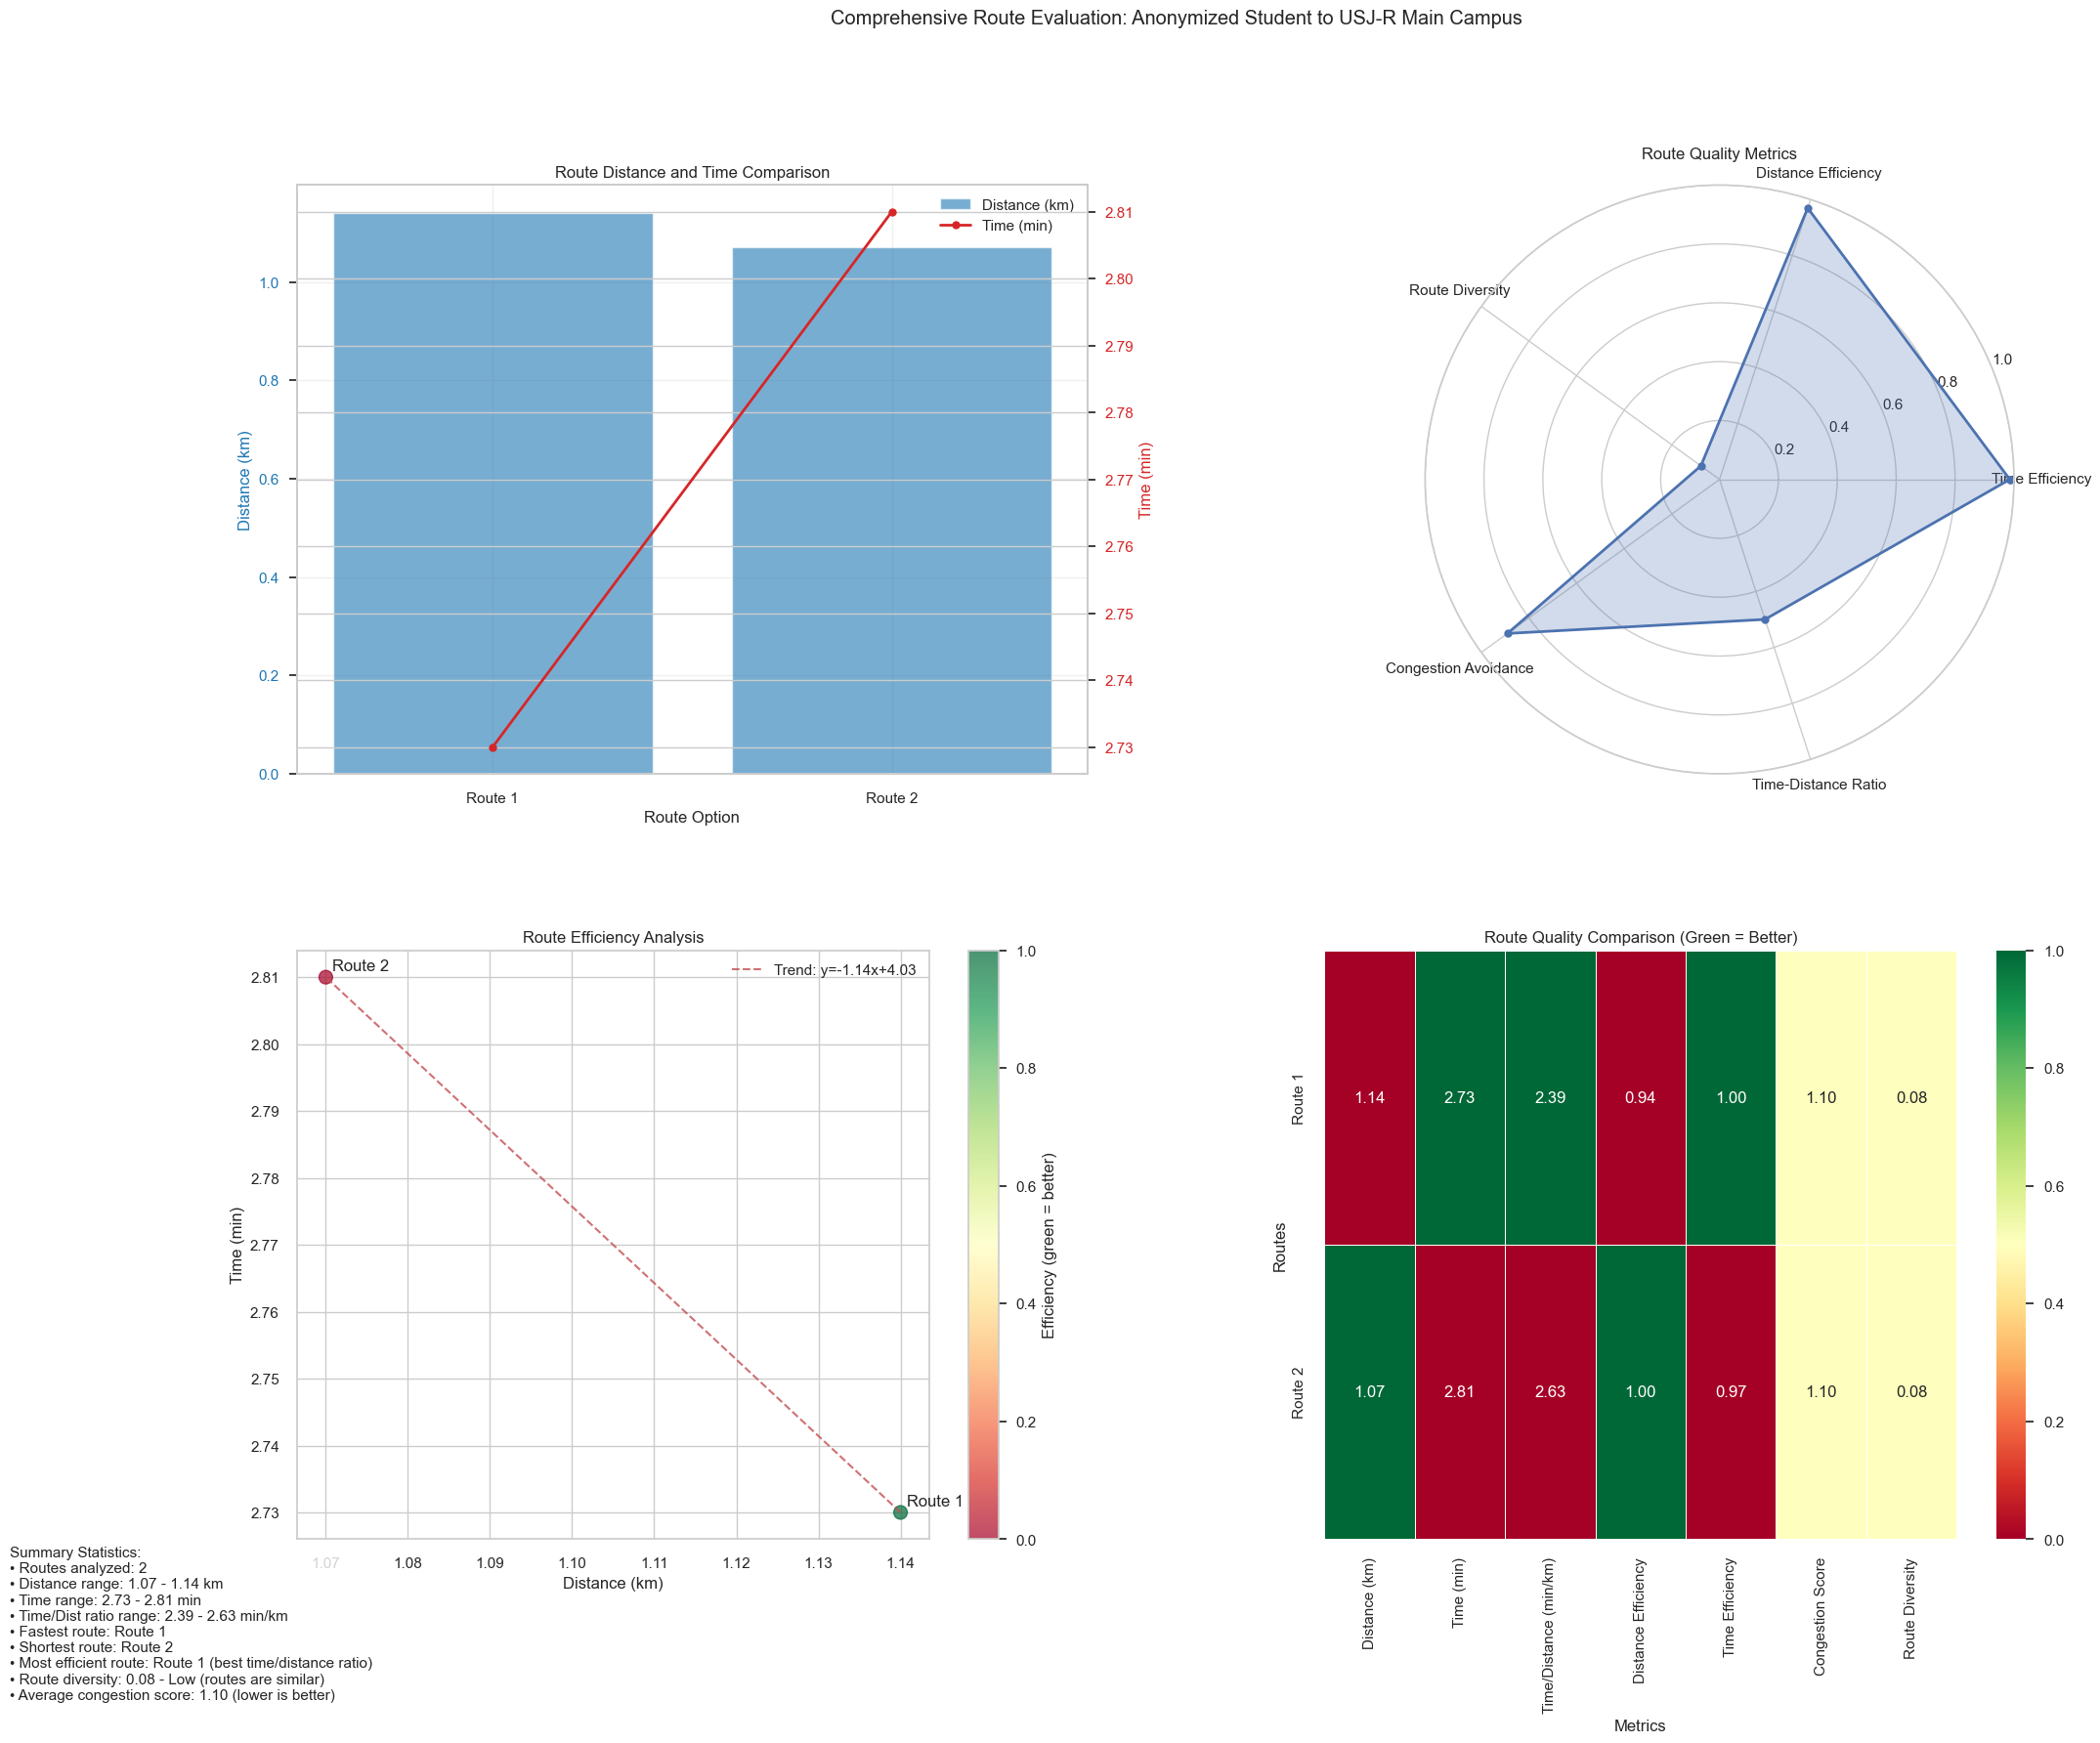

Fetching evaluation data for Unknown Student to USJ-R Basak Campus
Successfully fetched data for Unknown Student to USJ-R Basak Campus

Creating comprehensive visualization for Basak Campus...


C:\Users\USER\AppData\Local\Temp\ipykernel_14844\806745384.py:161: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved visualization to route_analysis_basak_20250402_073223.png


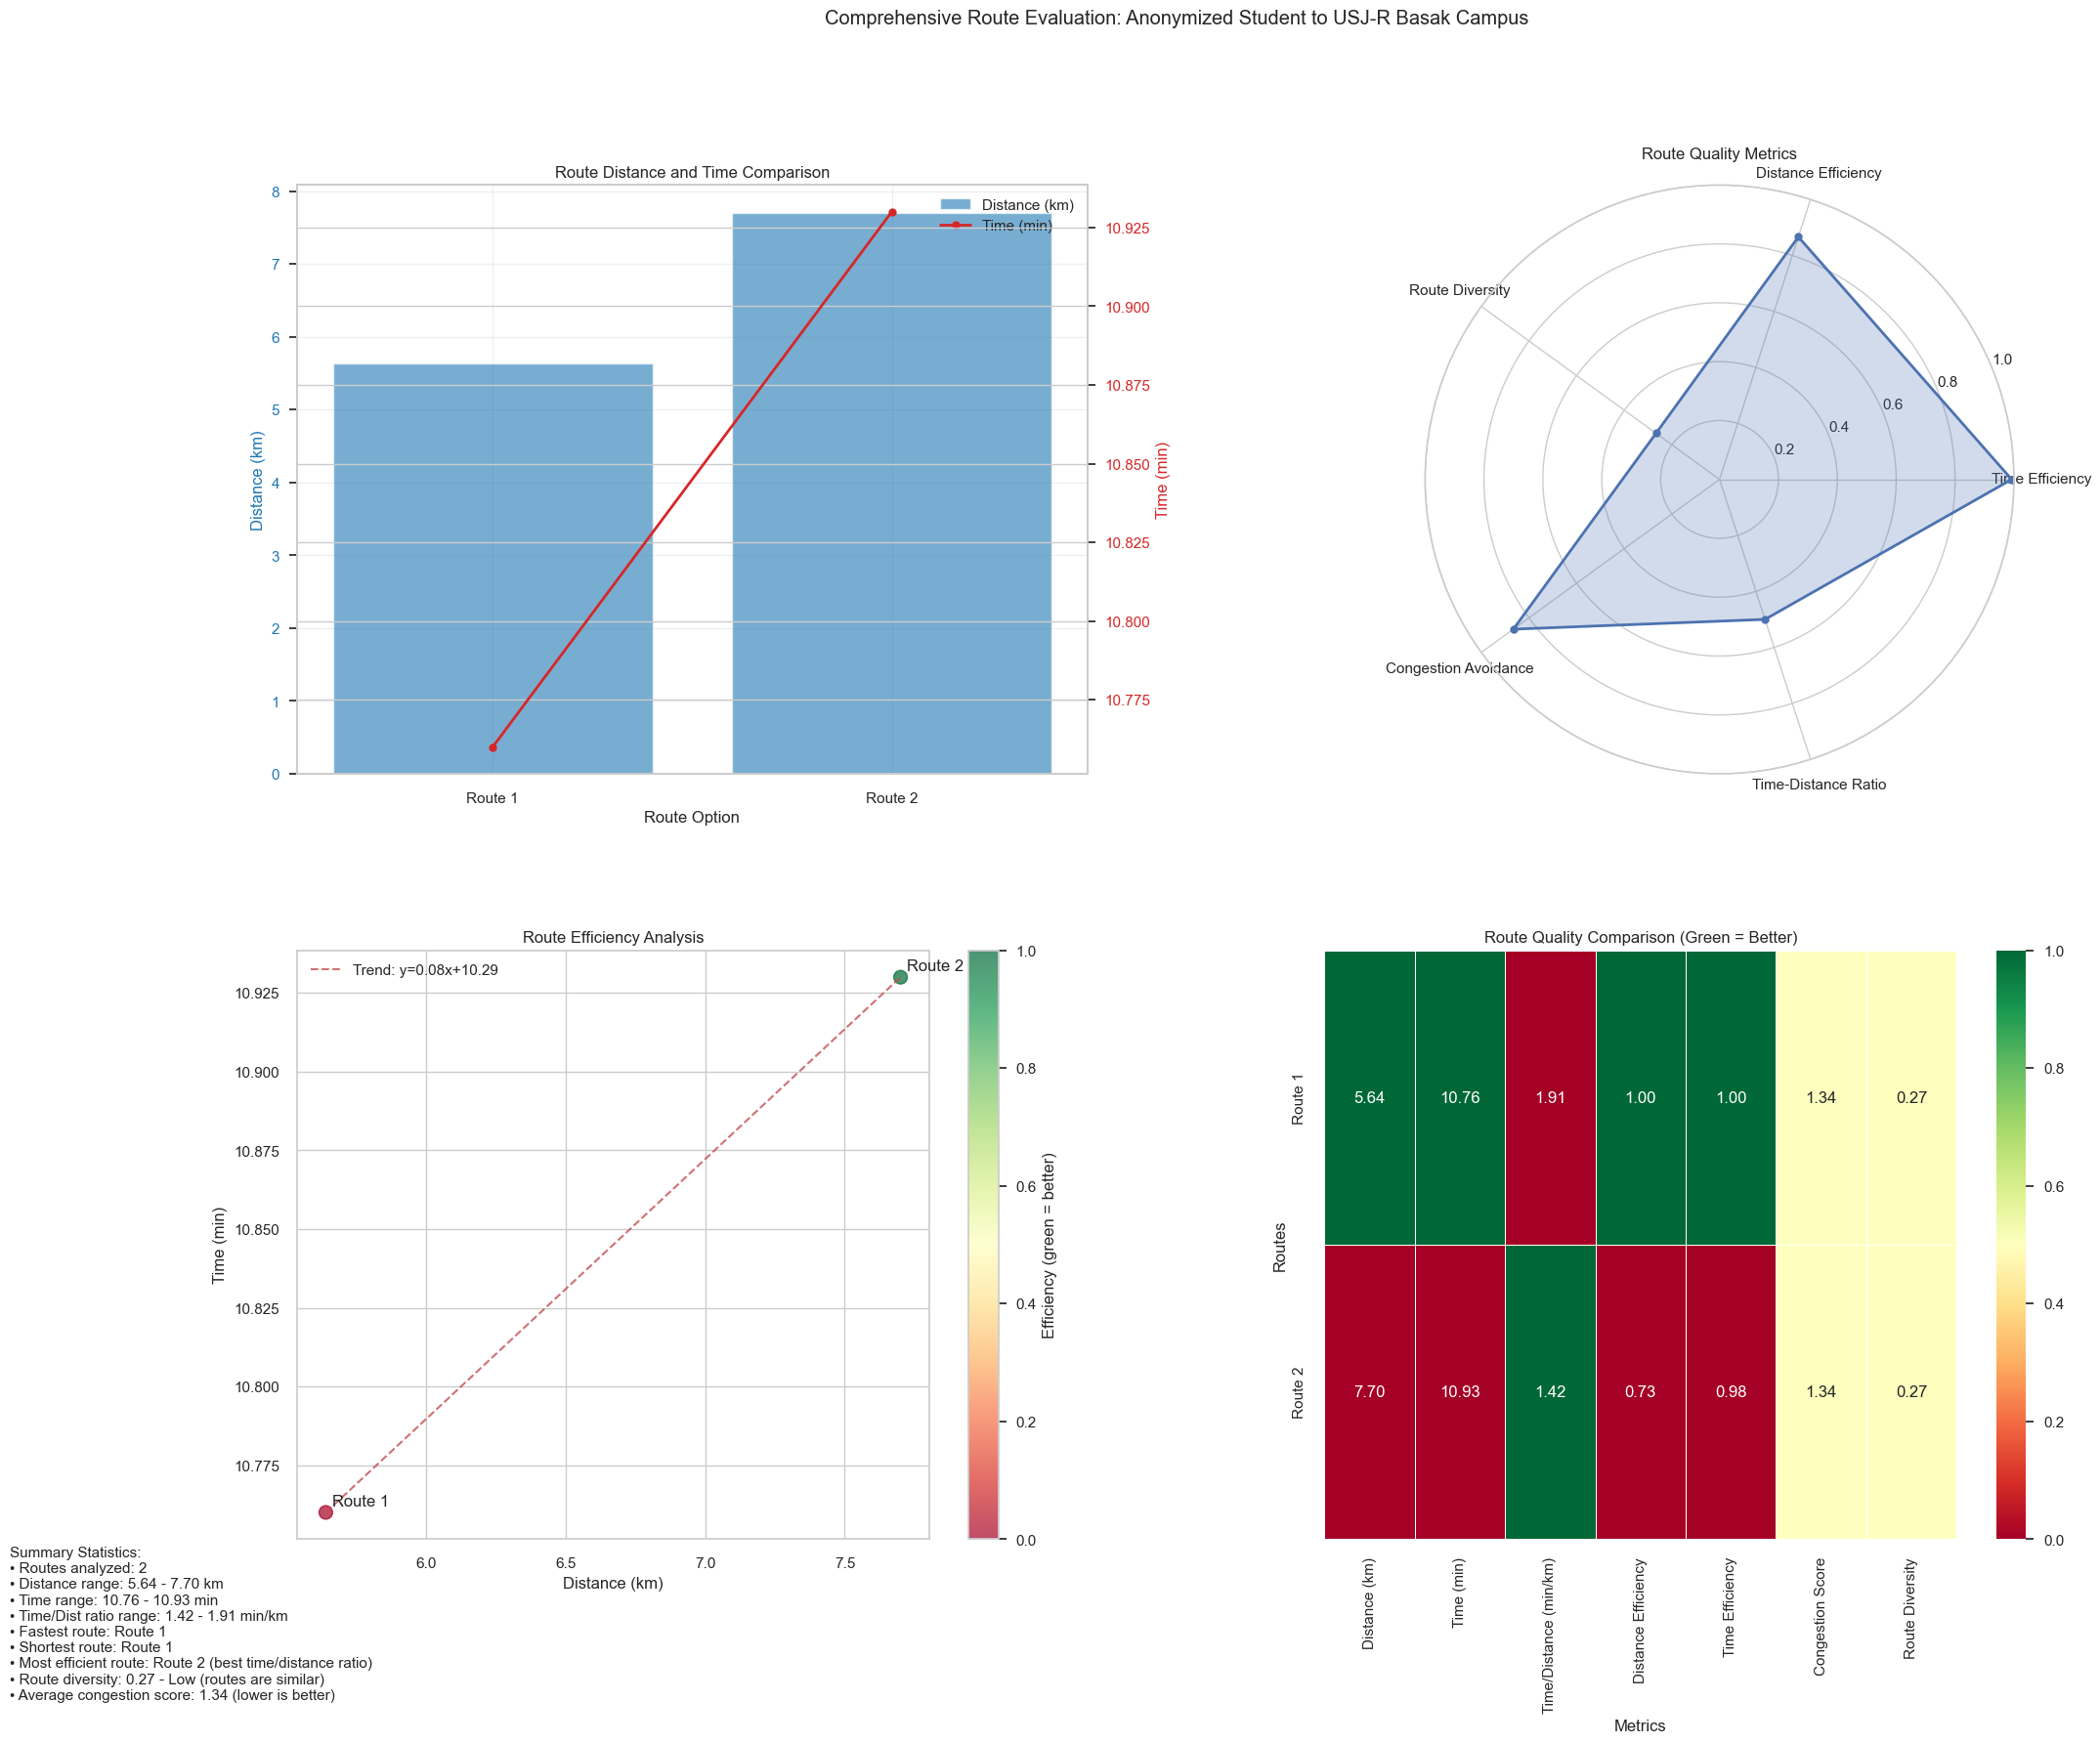


Analysis complete! Files saved with timestamp: 20250402_073223


In [113]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from datetime import datetime

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

def fetch_route_data(student="Unknown Student", campus="USJ-R Main Campus"):
    """
    Fetch the latest route evaluation data from the backend API.
    """
    API_URL = "http://localhost:8000/evaluate-routes"
    
    print(f"Fetching evaluation data for {student} to {campus}")
    
    try:
        response = requests.get(API_URL, params={
            "student_name": student,
            "campus_name": campus
        })
        
        response.raise_for_status()
        api_data = response.json()
        print(f"Successfully fetched data for {student} to {campus}")
        return api_data
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP Error: {http_err}")
        print(f"Response status: {response.status_code}")
        print(f"Response body: {response.text}")
        raise


def create_route_dataframe(route_data):
    """Convert route data into a pandas DataFrame for easier manipulation."""
    # Extract route metrics
    distances = route_data['distanceStats']['values']
    times = route_data['timeStats']['values']
    
    # Create route labels
    route_labels = [f"Route {i+1}" for i in range(len(distances))]
    
    # Calculate time-distance ratio (efficiency metric)
    time_distance_ratios = [t/d for t, d in zip(times, distances)]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Route': route_labels,
        'Distance (km)': distances,
        'Time (min)': times,
        'Time/Distance (min/km)': time_distance_ratios
    })
    
    # Calculate Distance Efficiency (shorter = better)
    min_distance = min(distances)
    df['Distance Efficiency'] = [min_distance/d for d in distances]  # Normalized 0-1, higher is better
    
    # Calculate Time Efficiency (shorter = better)
    min_time = min(times)
    df['Time Efficiency'] = [min_time/t for t in times]  # Normalized 0-1, higher is better
    
    # Add route quality metrics if available
    if 'efficiencyMetrics' in route_data:
        if 'routeQualityScores' in route_data['efficiencyMetrics']:
            df['Quality Score'] = route_data['efficiencyMetrics']['routeQualityScores']
        if 'congestionScore' in route_data['efficiencyMetrics']:
            # Congestion Score (inverted: lower = better)
            congestion_scores = route_data['efficiencyMetrics']['congestionScore']
            if isinstance(congestion_scores, list):
                df['Congestion Score'] = congestion_scores
            else:
                # If there's only one congestion score, use it for all routes
                df['Congestion Score'] = [congestion_scores] * len(route_labels)
            
            # Calculate inverse congestion (higher = better)
            max_congestion = 10  # Assuming congestion score is on a 0-10 scale
            df['Congestion Avoidance'] = [1 - (c/max_congestion) for c in df['Congestion Score']]
    
    # Calculate Route Diversity if not provided or default value
    if 'routeDiversity' not in route_data or route_data.get('routeDiversity', {}).get('diversityScore', 0.5) == 0.5:
        diversity_score = calculate_route_diversity(df)
        # Set the same diversity score for all routes
        df['Route Diversity'] = [diversity_score] * len(route_labels)
    else:
        df['Route Diversity'] = [route_data['routeDiversity']['diversityScore']] * len(route_labels)
    
    return df

def calculate_route_diversity(df):
    """
    Calculate route diversity based on time and distance variations.
    Higher score means routes are more diverse (offer truly different options).
    """
    if len(df) <= 1:
        return 0.5
    
    # Calculate coefficient of variation for time and distance
    cv_time = df['Time (min)'].std() / df['Time (min)'].mean() if df['Time (min)'].mean() > 0 else 0
    cv_dist = df['Distance (km)'].std() / df['Distance (km)'].mean() if df['Distance (km)'].mean() > 0 else 0
    
    # Calculate route time-distance ratio variation
    cv_ratio = df['Time/Distance (min/km)'].std() / df['Time/Distance (min/km)'].mean() if df['Time/Distance (min/km)'].mean() > 0 else 0
    
    # Combine metrics (weighted average of coefficients of variation)
    diversity_score = (cv_time * 0.4 + cv_dist * 0.4 + cv_ratio * 0.2)
    
    # Scale to 0-1 range (empirically, values above 0.25 indicate good diversity)
    diversity = min(1.0, diversity_score * 2)
    
    return diversity

def visualize_comprehensive_evaluation(route_data, save_path=None):
    """Create a comprehensive dashboard of route evaluation metrics."""
    # Create a DataFrame for easier manipulation
    df = create_route_dataframe(route_data)
    
    # Set up the figure with a grid layout
    fig = plt.figure(figsize=(24, 18))
    gs = gridspec.GridSpec(
        nrows=2, 
        ncols=2, 
        figure=fig,
        height_ratios=[1, 1],
        hspace=0.3,
        wspace=0.3
    )
    
    # Extract metadata
    student = route_data['metadata']['studentName']
    campus = route_data['metadata']['campusName']
    route_count = route_data['metadata']['routeCount']
    
    # Add a title to the entire figure
    fig.suptitle(f'Comprehensive Route Evaluation: Anonymized Student to {campus}\n')
    
    # 1. Distance and Time Comparison (Bar & Line)
    ax1 = fig.add_subplot(gs[0, 0])
    create_distance_time_plot(df, ax1)
    
    # 2. Route Quality Radar Chart
    ax2 = fig.add_subplot(gs[0, 1], polar=True)
    create_route_quality_radar(route_data, df, ax2)
    
    # 3. Route Efficiency Scatter Plot
    ax3 = fig.add_subplot(gs[1, 0])
    create_efficiency_scatter(df, ax3)
    
    # 4. Route Quality Heatmap
    ax4 = fig.add_subplot(gs[1, 1])
    create_route_quality_heatmap(route_data, df, ax4)
    
    # Add summary statistics as text
    add_summary_statistics(route_data, df, fig)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()
    
    return df

def create_distance_time_plot(df, ax):
    """Create a combined distance (bar) and time (line) plot."""
    route_labels = df['Route']
    distances = df['Distance (km)']
    times = df['Time (min)']
    
    # Plot distance bars
    color1 = 'tab:blue'
    ax.bar(route_labels, distances, color=color1, alpha=0.6, label='Distance (km)')
    ax.set_xlabel('Route Option')
    ax.set_ylabel('Distance (km)', color=color1)
    ax.tick_params(axis='y', labelcolor=color1)
    
    # Create twin axis for time
    ax2 = ax.twinx()
    color2 = 'tab:red'
    ax2.plot(route_labels, times, color=color2, marker='o', linestyle='-', 
             linewidth=2, label='Time (min)')
    ax2.set_ylabel('Time (min)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    ax.set_title('Route Distance and Time Comparison')
    ax.grid(True, alpha=0.3)

def create_route_quality_radar(route_data, df, ax):
    """Create a radar chart showing route quality metrics."""
    # Define categories for radar chart
    categories = ['Time Efficiency', 'Distance Efficiency', 
                  'Route Diversity', 'Congestion Avoidance', 'Time-Distance Ratio']
    
    # Extract values (normalize between 0-1)
    values = []
    
    # Time efficiency (shorter = better)
    values.append(df['Time Efficiency'].mean())
    
    # Distance efficiency (shorter = better)
    values.append(df['Distance Efficiency'].mean())
    
    # Route diversity
    diversity = df['Route Diversity'].iloc[0]
    values.append(diversity)
    
    # Congestion avoidance
    if 'Congestion Avoidance' in df.columns:
        values.append(df['Congestion Avoidance'].mean())
    else:
        # Default value if not available
        values.append(0.5)
    
    # Time-Distance Ratio (inverted: lower raw value = better)
    # Calculate normalized inverse of time/distance ratio
    min_ratio = df['Time/Distance (min/km)'].min()
    max_ratio = df['Time/Distance (min/km)'].max()
    if min_ratio == max_ratio:
        ratio_score = 0.5
    else:
        avg_ratio = df['Time/Distance (min/km)'].mean()
        ratio_score = 1 - ((avg_ratio - min_ratio) / (max_ratio - min_ratio))
    values.append(ratio_score)
    
    # Make sure all values are numeric
    for i, val in enumerate(values):
        if not isinstance(val, (int, float)) or np.isnan(val):
            values[i] = 0.5
    
    # Calculate angles for each category
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    
    # Close the loop for both angles and values
    values.append(values[0])
    categories.append(categories[0])
    angles.append(angles[0])
    
    # Now both values and angles have the same length
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories[:-1])
    ax.set_ylim(0, 1)
    ax.set_title('Route Quality Metrics')
    ax.grid(True)

def create_efficiency_scatter(df, ax):
    """Create a scatter plot of time vs distance with efficiency indicators."""
    # Use time/distance ratio for color (inverted: lower = better)
    ratios = df['Time/Distance (min/km)']
    
    # Normalize ratios for coloring (lower raw ratio is better, so invert for color)
    min_ratio = ratios.min()
    max_ratio = ratios.max()
    if min_ratio == max_ratio:
        normalized_ratios = [0.5] * len(ratios)
    else:
        normalized_ratios = [1 - ((r - min_ratio) / (max_ratio - min_ratio)) for r in ratios]
    
    # Create scatter plot
    scatter = ax.scatter(df['Distance (km)'], df['Time (min)'], 
                         c=normalized_ratios, cmap='RdYlGn', 
                         s=100, alpha=0.7, 
                         norm=plt.Normalize(0, 1))  # Use full color range
    
    # Add route labels
    for i, row in df.iterrows():
        ax.annotate(row['Route'], 
                    (row['Distance (km)'], row['Time (min)']),
                    xytext=(5, 5), textcoords='offset points')
    
    # Add color bar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Efficiency (green = better)')
    
    # Add a line of best fit
    x = df['Distance (km)']
    y = df['Time (min)']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8, label=f"Trend: y={z[0]:.2f}x+{z[1]:.2f}")
    
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Time (min)')
    ax.set_title('Route Efficiency Analysis')
    ax.grid(True)
    ax.legend()

def create_route_quality_heatmap(route_data, df, ax):
    """Create a heatmap showing route quality metrics for each route."""
    # Extract metrics
    route_labels = df['Route']
    
    # Define metrics to include in heatmap
    metrics_to_include = [
        'Distance (km)', 
        'Time (min)', 
        'Time/Distance (min/km)',
        'Distance Efficiency',
        'Time Efficiency'
    ]
    
    # Add congestion score if available
    if 'Congestion Score' in df.columns:
        metrics_to_include.append('Congestion Score')
    
    # Add route diversity
    if 'Route Diversity' in df.columns:
        metrics_to_include.append('Route Diversity')
    
    # Add quality score if available
    if 'Quality Score' in df.columns:
        metrics_to_include.append('Quality Score')
    
    # Select data for heatmap
    heatmap_data = df[metrics_to_include].copy()
    heatmap_data.index = route_labels
    
    # Create a normalized version for the heatmap colors
    normalized_data = heatmap_data.copy()
    
    # For each metric, normalize appropriately (some lower is better, some higher is better)
    for col in normalized_data.columns:
        col_min = normalized_data[col].min()
        col_max = normalized_data[col].max()
        if col_min == col_max:
            normalized_data[col] = 0.5  # All values are the same
        else:
            if col in ['Distance (km)', 'Time (min)', 'Time/Distance (min/km)', 'Congestion Score']:
                # For these metrics, lower is better - normalize and invert
                normalized_data[col] = 1 - ((normalized_data[col] - col_min) / (col_max - col_min))
            else:
                # For these metrics, higher is better - normalize directly
                normalized_data[col] = (normalized_data[col] - col_min) / (col_max - col_min)
    
    # Create the heatmap
    sns.heatmap(normalized_data, annot=heatmap_data.round(2), fmt=".2f", 
                cmap="RdYlGn", ax=ax, linewidths=0.5)
    
    ax.set_title('Route Quality Comparison (Green = Better)')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Routes')

def add_summary_statistics(route_data, df, fig):
    """Add summary statistics as text to the figure."""
    # Calculate additional statistics
    best_time_route = df.loc[df['Time (min)'].idxmin(), 'Route']
    best_distance_route = df.loc[df['Distance (km)'].idxmin(), 'Route']
    best_ratio_route = df.loc[df['Time/Distance (min/km)'].idxmin(), 'Route']
    
    # Create a text box with summary statistics
    summary_text = (
        f"Summary Statistics:\n"
        f"• Routes analyzed: {route_data['metadata']['routeCount']}\n"
        f"• Distance range: {df['Distance (km)'].min():.2f} - {df['Distance (km)'].max():.2f} km\n"
        f"• Time range: {df['Time (min)'].min():.2f} - {df['Time (min)'].max():.2f} min\n"
        f"• Time/Dist ratio range: {df['Time/Distance (min/km)'].min():.2f} - {df['Time/Distance (min/km)'].max():.2f} min/km\n"
        f"• Fastest route: {best_time_route}\n"
        f"• Shortest route: {best_distance_route}\n"
        f"• Most efficient route: {best_ratio_route} (best time/distance ratio)\n"
    )
    
    # Add route diversity
    route_diversity = df['Route Diversity'].iloc[0]
    summary_text += f"• Route diversity: {route_diversity:.2f} - "
    
    if route_diversity < 0.3:
        summary_text += "Low (routes are similar)\n"
    elif route_diversity < 0.7:
        summary_text += "Medium (some route variations)\n"
    else:
        summary_text += "High (diverse route options)\n"
    
    # Add congestion information if available
    if 'Congestion Score' in df.columns:
        avg_congestion = df['Congestion Score'].mean()
        summary_text += f"• Average congestion score: {avg_congestion:.2f} (lower is better)\n"
   
    # Add text to the figure
    fig.text(0.0025, 0.01, summary_text, fontsize=11, 
             bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

# Function to safely extract metrics from API data with default values
def extract_metric_with_default(data, metric_path, default_value=None):
    """Safely extract metrics from nested dictionaries with fallback defaults."""
    current = data
    for key in metric_path.split('.'):
        if isinstance(current, dict) and key in current:
            current = current[key]
        else:
            return default_value
    return current

# --- Main function to run the comprehensive analysis ---
def run_comprehensive_analysis(student_name="Unknown Student"):
    """Run a comprehensive analysis for a student to all campuses."""
    # Current timestamp for output files
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    try:
        # Analyze for main campus
        main_campus_data = fetch_route_data(student=student_name, campus="USJ-R Main Campus")
        print("\nCreating comprehensive visualization for Main Campus...")
        main_df = visualize_comprehensive_evaluation(
            main_campus_data, 
            save_path=f"route_analysis_main_{timestamp}.png"
        )
        
        # Try to analyze for Basak campus
        try:
            basak_campus_data = fetch_route_data(student=student_name, campus="USJ-R Basak Campus")
            print("\nCreating comprehensive visualization for Basak Campus...")
            basak_df = visualize_comprehensive_evaluation(
                basak_campus_data,
                save_path=f"route_analysis_basak_{timestamp}.png"
            )
        except Exception as e:
            print(f"Error processing Basak Campus: {e}")
            import traceback
            traceback.print_exc()

        print(f"\nAnalysis complete! Files saved with timestamp: {timestamp}")
        return True        
    
    except Exception as e:
        print(f"Error in comprehensive analysis: {e}")
        import traceback
        traceback.print_exc()
        return False

# Run the analysis if this script is executed directly
if __name__ == "__main__":
    run_comprehensive_analysis()